#  <span style = "color : red"> Importing Libraries </span>

In [15]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools, AllChem, MACCSkeys, RDConfig
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
from rdkit.Chem.Pharm2D import Generate
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

#  <span style = "color : red"> Train Data Preparation </span>

In [16]:
sdf_file ='./dataset/logBB.sdf'
suppl = Chem.SDMolSupplier(sdf_file)
molecules = [mol for mol in suppl if mol is not None]
df = PandasTools.LoadSDF(sdf_file)
df.head()

,name,logBB,logBB_class,HAC,ID,ROMol,StandardizerResult
0,methylchloroform,0.4,1,5,MolID_203,<rdkit.Chem.rdchem.Mol object at 0x000002628B1...,NaN
1,vinyltrichloride,-0.1,0,5,MolID_330,<rdkit.Chem.rdchem.Mol object at 0x000002628B1...,NaN
2,"1,1-difluorochloroethylene",-0.02,0,5,MolID_12,<rdkit.Chem.rdchem.Mol object at 0x000002628B1...,NaN
3,1-butanol,-0.02,0,5,MolID_17,<rdkit.Chem.rdchem.Mol object at 0x000002628B1...,NaN
4,2-butanone,-0.07,0,5,MolID_28,<rdkit.Chem.rdchem.Mol object at 0x000002628B1...,NaN


In [17]:
df['SMILES'] = df['ROMol'].apply(Chem.MolToSmiles)
selected_columns = df[['name', 'SMILES', 'logBB', 'logBB_class']]
output_file = './qsar_classification_training.csv'
selected_columns.to_csv(output_file, index=False)

#  <span style = "color : red"> Test Data Preparation </span>

In [18]:
sdf_file = './dataset/logBB_test_.sdf'
suppl = Chem.SDMolSupplier(sdf_file)
molecules = [mol for mol in suppl if mol is not None]
df = PandasTools.LoadSDF(sdf_file)
df.head()

,p_np,ID,ROMol,Double bonds,Undefined stereocenters
0,1,MolID_1,<rdkit.Chem.rdchem.Mol object at 0x000002628B1...,NaN,NaN
1,0,MolID_2,<rdkit.Chem.rdchem.Mol object at 0x000002628B1...,NaN,NaN
2,1,MolID_3,<rdkit.Chem.rdchem.Mol object at 0x000002628B1...,NaN,NaN
3,1,MolID_4,<rdkit.Chem.rdchem.Mol object at 0x000002628B1...,NaN,NaN
4,0,MolID_5,<rdkit.Chem.rdchem.Mol object at 0x000002628B1...,NaN,NaN


In [19]:

df['SMILES'] = df['ROMol'].apply(Chem.MolToSmiles)
selected_columns = df[['SMILES', 'p_np']]
output_file = './qsar_classification_testing.csv'
selected_columns.to_csv(output_file, index=False)

In [20]:
df_train = pd.read_csv('qsar_classification_training.csv')
train_smile = df_train['SMILES']
df_test = pd.read_csv('qsar_classification_testing.csv')
test_smile = df_test['SMILES']

#  <span style = "color : red"> Atom Pair Fingerprint </span>

In [21]:
def fingerprint_atom_pair_smiles_list(
        smiles,
        len_fingerprint=2048,
        min_atom_pair_len=1,
        max_atom_pair_len=30,
        from_atoms=0,
        ignore_atoms=0,
        atom_invariants=0,
        bits_per_entry=4,
        Chirality=False,
        use_2D=True,
        conf_Id=-1
):
    fingerprint_rep = [None] * len(smiles)
    for i, sm in enumerate(smiles):
        mol = Chem.MolFromSmiles(sm)
        if mol is not None:
            fingerprint_bin = AllChem.GetHashedAtomPairFingerprintAsBitVect(
                mol, nBits=len_fingerprint, minLength=min_atom_pair_len,
                maxLength=max_atom_pair_len, fromAtoms=from_atoms,
                ignoreAtoms=ignore_atoms, atomInvariants=atom_invariants,
                nBitsPerEntry=bits_per_entry, includeChirality=Chirality,
                use2D=use_2D, confId=conf_Id
            )
            fingerprint_rep[i] = fingerprint_bin.ToBitString()

    return fingerprint_rep


In [22]:
train_input_features_atom_pair = fingerprint_atom_pair_smiles_list(train_smile)
test_input_features_atom_pair = fingerprint_atom_pair_smiles_list(test_smile)

In [23]:
df_train.head()

,name,SMILES,logBB,logBB_class
0,methylchloroform,CC(Cl)(Cl)Cl,0.40,1
1,vinyltrichloride,ClCC(Cl)Cl,-0.10,0
2,"1,1-difluorochloroethylene",FC(F)=CCl,-0.02,0
3,1-butanol,CCCCO,-0.02,0
4,2-butanone,CCC(C)=O,-0.07,0


In [24]:
df_test.head()

,SMILES,p_np
0,CN1CCC2=C(CC1)c1ccccc1Oc1ccccc12,1
1,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,0
2,CCN(CC)CCN1C(=O)CN=C(c2ccccc2F)c2cc(Cl)ccc21,1
3,CC(=O)Nc1ccc(OC(=O)[C@@H]2CCC(=O)N2)cc1,1
4,COC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1ccccc1[N+](=...,0


###  <span style = "color : lightgreen"> Making Train and Test Dataframe </span>

In [25]:
input_train_descriptor = []
for binary_string in train_input_features_atom_pair:
    output_list = [int(bit) for bit in binary_string]
    input_train_descriptor.append(output_list)
train_descriptor_frame_atom_pair = pd.DataFrame(input_train_descriptor)
train_descriptor_frame_atom_pair.columns = [f'descriptor_{i+1}' for i in range(2048)]
train_descriptor_frame_atom_pair['class'] = df_train['logBB_class']

In [26]:
input_test_descriptor = []
for binary_string in test_input_features_atom_pair:
    output_list = [int(bit) for bit in binary_string]
    input_test_descriptor.append(output_list)
test_descriptor_frame_atom_pair = pd.DataFrame(input_test_descriptor)
test_descriptor_frame_atom_pair.columns = [f'descriptor_{i+1}' for i in range(2048)]
test_descriptor_frame_atom_pair['class'] = df_test['p_np']

##  <span style = "color : lightgreen"> Splitting into Train and Validation and Test Set </span>

In [27]:
X = train_descriptor_frame_atom_pair.drop(columns='class')
y = train_descriptor_frame_atom_pair['class']
class_0 = train_descriptor_frame_atom_pair[train_descriptor_frame_atom_pair['class'] == 0]
class_1 = train_descriptor_frame_atom_pair[train_descriptor_frame_atom_pair['class'] == 1]

class_0_val = class_0.sample(frac=0.1, random_state=42)
class_1_val = class_1.sample(frac=0.1, random_state=42)

validation_set = pd.concat([class_0_val, class_1_val])

class_0_train = class_0.drop(class_0_val.index)
class_1_train = class_1.drop(class_1_val.index)

training_set = pd.concat([class_0_train, class_1_train])

X_train = training_set.drop(columns='class')
y_train = training_set['class']
X_val = validation_set.drop(columns='class')
y_val = validation_set['class']

validation_set = validation_set.reset_index().rename(columns={'index': 'index'})
validation_set.to_csv('validation_set_atom_pair.csv', index=False)

X_test = test_descriptor_frame_atom_pair.drop(columns='class')
y_test = test_descriptor_frame_atom_pair['class']

##  <span style = "color : Orange"> Random Forest </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [28]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 15],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

best_accuracy_diff = float('inf')
atom_pair_best_params_rf = {}
results = []

for n_estimators in param_grid['n_estimators']:
    for min_samples_leaf in param_grid['min_samples_leaf']:
        for bootstrap in param_grid['bootstrap']:
            for criterion in param_grid['criterion']:
                for max_features in param_grid['max_features']:
                    rf_classifier = RandomForestClassifier(
                        n_estimators=n_estimators,
                        min_samples_leaf=min_samples_leaf,
                        bootstrap=bootstrap,
                        criterion=criterion,
                        max_features=max_features,
                        random_state=42
                    )
                    rf_classifier.fit(X_train, y_train)
                    y_pred_train = rf_classifier.predict(X_train)
                    y_pred_val = rf_classifier.predict(X_val)
                    y_pred_test = rf_classifier.predict(X_test)
                    
                    train_accuracy = accuracy_score(y_train, y_pred_train)
                    validation_accuracy = accuracy_score(y_val, y_pred_val)
                    test_accuracy = accuracy_score(y_test, y_pred_test)
                    accuracy_diff = abs(train_accuracy - test_accuracy)
                    
                    results.append({
                        'n_estimators': n_estimators,
                        'min_samples_leaf': min_samples_leaf,
                        'bootstrap': bootstrap,
                        'criterion': criterion,
                        'max_features': max_features,
                        'train_accuracy': train_accuracy,
                        'validation_accuracy': validation_accuracy,
                        'test_accuracy': test_accuracy,
                        'accuracy_diff': accuracy_diff
                    })
                    
                    if accuracy_diff < best_accuracy_diff:
                        best_accuracy_diff = accuracy_diff
                        atom_pair_best_params_rf = {
                            'n_estimators': n_estimators,
                            'min_samples_leaf': min_samples_leaf,
                            'bootstrap': bootstrap,
                            'criterion': criterion,
                            'max_features': max_features
                        }

results_df = pd.DataFrame(results)
results_df.to_csv('rf_hyperparameter_tuning_atom_pair.csv', index=False)

print("Best hyperparameters for Random Forest:")
print(atom_pair_best_params_rf)

Best hyperparameters for Random Forest:
{'n_estimators': 100, 'min_samples_leaf': 6, 'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2'}


###  <span style = "color : lightgreen"> Model Training with the best parameters || Validation || Performance in the Test set </span>

In [29]:
best_rf_classifier = RandomForestClassifier(**atom_pair_best_params_rf, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_rf_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

# Model Performance on Test Set
y_pred_test = best_rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7947761194029851
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.6333333333333333
--------------------------------------------------------------------------
Confusion Matrix:
[[ 3  9]
 [ 2 16]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.25      0.35        12
           1       0.64      0.89      0.74        18

    accuracy                           0.63        30
   macro avg       0.62      0.57      0.55        30
weighted avg       0.62      0.63      0.59        30

--------------------------------------------------------------------------
-------------------------------------------

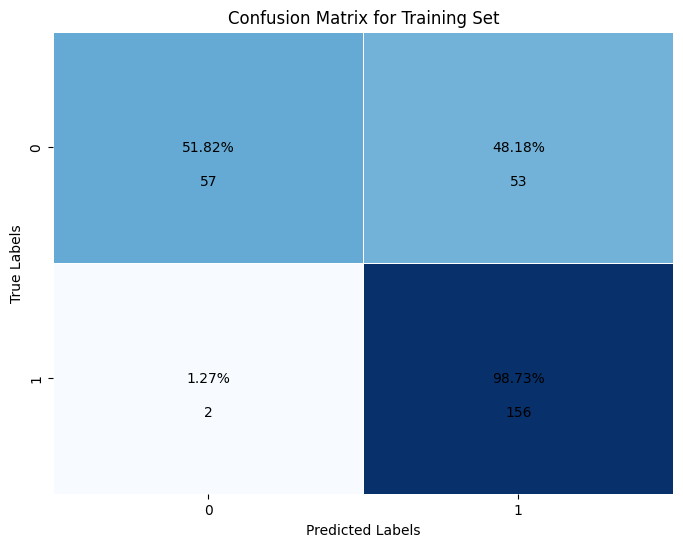

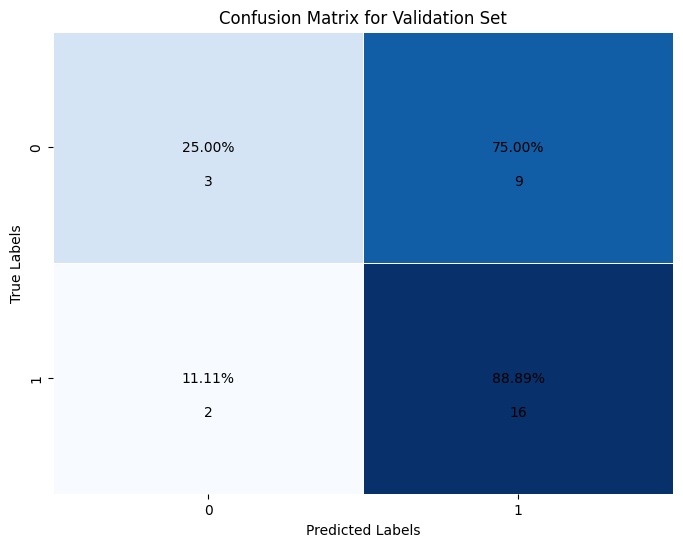

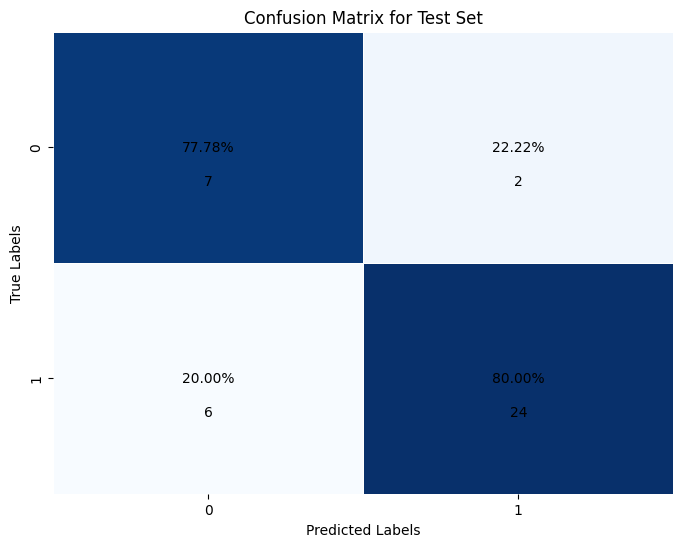

In [30]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

##  <span style = "color : Orange"> Support Vector Machine </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [31]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]  # only relevant for 'poly' kernel
}

best_accuracy_diff = float('inf')
atom_pair_best_params_svm = {}
results = []

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:
            for degree in param_grid['degree']:
                if kernel == 'poly':
                    svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, random_state=42)
                else:
                    svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel, random_state=42)
                svm_classifier.fit(X_train, y_train)
                y_pred_train = svm_classifier.predict(X_train)
                y_pred_val = svm_classifier.predict(X_val)
                y_pred_test = svm_classifier.predict(X_test)
                
                train_accuracy = accuracy_score(y_train, y_pred_train)
                validation_accuracy = accuracy_score(y_val, y_pred_val)
                test_accuracy = accuracy_score(y_test, y_pred_test)
                accuracy_diff = abs(train_accuracy - test_accuracy)
                
                results.append({
                    'C': C,
                    'gamma': gamma,
                    'kernel': kernel,
                    'degree': degree,
                    'train_accuracy': train_accuracy,
                    'validation_accuracy': validation_accuracy,
                    'test_accuracy': test_accuracy,
                    'accuracy_diff': accuracy_diff
                })
                
                if accuracy_diff < best_accuracy_diff:
                    best_accuracy_diff = accuracy_diff
                    atom_pair_best_params_svm = {
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel,
                        'degree': degree
                    }

results_df = pd.DataFrame(results)
results_df.to_csv('svm_hyperparameter_tuning_atom_pair.csv', index=False)

print("Best hyperparameters for SVM:")
print(atom_pair_best_params_svm)

Best hyperparameters for SVM:
{'C': 100, 'gamma': 'auto', 'kernel': 'poly', 'degree': 2}


###  <span style = "color : lightgreen"> Model Training with the best parameters || Validation || Model performance on Test set </span>

In [32]:
best_svm_classifier = SVC(**atom_pair_best_params_svm, random_state=42)
best_svm_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_svm_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_svm_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

# Model Performance on Test Set
y_pred_test = best_svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7873134328358209
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.6666666666666666
--------------------------------------------------------------------------
Confusion Matrix:
[[ 3  9]
 [ 1 17]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.25      0.38        12
           1       0.65      0.94      0.77        18

    accuracy                           0.67        30
   macro avg       0.70      0.60      0.57        30
weighted avg       0.69      0.67      0.61        30

--------------------------------------------------------------------------
-------------------------------------------

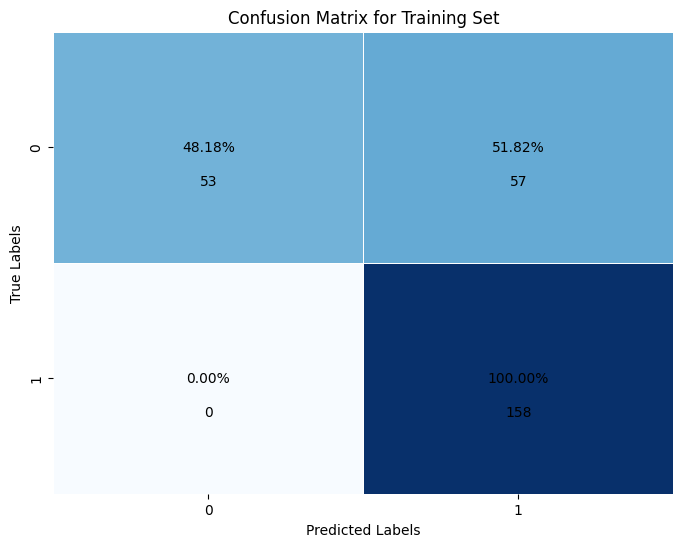

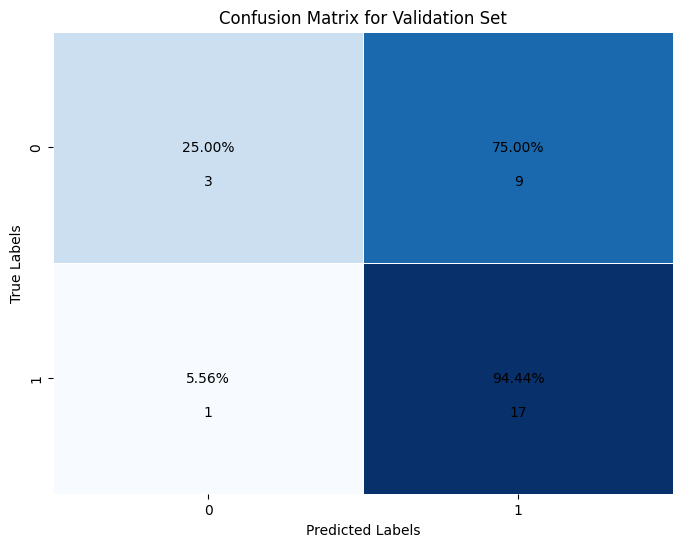

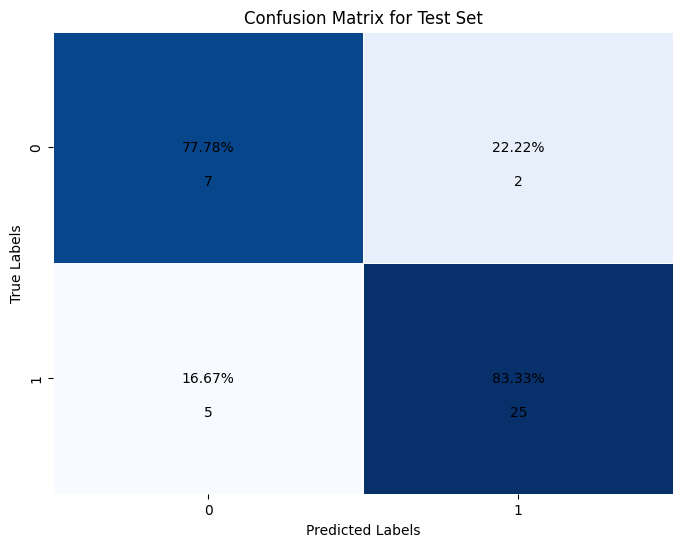

In [33]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

# <span style = "color : red"> Extended Connectivity Fingerprint </span>


In [34]:
def fingerprint_extended_connectivity_smiles_list(
        smiles,
        radius = 2,
        len_fingerprint=2048,
        from_atoms=0,
        atom_invariants=0,
        Chirality=False,
        Bond_Types=True,
        use_Features=False,
        bitInfo=None,
        RedundantEnvironments=False
):
    fingerprint_rep = [None] * len(smiles)

    for i, sm in enumerate(smiles):
        mol = Chem.MolFromSmiles(sm)
        if mol is not None:
            fingerprint_bin = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=len_fingerprint, 
                                                                invariants=atom_invariants, fromAtoms=from_atoms,
                                                                useChirality=Chirality, useBondTypes=Bond_Types,
                                                                useFeatures=use_Features, bitInfo=bitInfo,
                                                                 includeRedundantEnvironments=RedundantEnvironments ) 
            fingerprint_rep[i] = fingerprint_bin.ToBitString()
            
    return fingerprint_rep


In [35]:
train_input_features_ecfp = fingerprint_extended_connectivity_smiles_list(train_smile)
test_input_features_ecfp = fingerprint_extended_connectivity_smiles_list(test_smile)

###  <span style = "color : lightgreen"> Making Train and Test Dataframe </span>

In [36]:
input_train_descriptor = []
for binary_string in train_input_features_ecfp:
    output_list = [int(bit) for bit in binary_string]
    input_train_descriptor.append(output_list)
train_descriptor_frame_ecfp = pd.DataFrame(input_train_descriptor)
train_descriptor_frame_ecfp.columns = [f'descriptor_{i+1}' for i in range(2048)]
train_descriptor_frame_ecfp['class'] = df_train['logBB_class']

input_test_descriptor = []
for binary_string in test_input_features_ecfp:
    output_list = [int(bit) for bit in binary_string]
    input_test_descriptor.append(output_list)
test_descriptor_frame_ecfp = pd.DataFrame(input_test_descriptor)
test_descriptor_frame_ecfp.columns = [f'descriptor_{i+1}' for i in range(2048)]
test_descriptor_frame_ecfp['class'] = df_test['p_np']

##  <span style = "color : lightgreen"> Splitting into Train and Validation and Test Set </span>

In [37]:
X = train_descriptor_frame_ecfp.drop(columns='class')
y = train_descriptor_frame_ecfp['class']
class_0 = train_descriptor_frame_ecfp[train_descriptor_frame_ecfp['class'] == 0]
class_1 = train_descriptor_frame_ecfp[train_descriptor_frame_ecfp['class'] == 1]

class_0_val = class_0.sample(frac=0.1, random_state=42)
class_1_val = class_1.sample(frac=0.1, random_state=42)

validation_set = pd.concat([class_0_val, class_1_val])
class_0_train = class_0.drop(class_0_val.index)
class_1_train = class_1.drop(class_1_val.index)

training_set = pd.concat([class_0_train, class_1_train])
X_train = training_set.drop(columns='class')
y_train = training_set['class']
X_val = validation_set.drop(columns='class')
y_val = validation_set['class']

validation_set = validation_set.reset_index().rename(columns={'index': 'index'})
validation_set.to_csv('validation_set_ecfp.csv', index=False)

print("Training set distribution:")
print(training_set['class'].value_counts())
print("Validation set distribution:")
print(validation_set['class'].value_counts())


X_test = test_descriptor_frame_ecfp.drop(columns='class')
y_test = test_descriptor_frame_ecfp['class']

Training set distribution:
class
1    158
0    110
Name: count, dtype: int64
Validation set distribution:
class
1    18
0    12
Name: count, dtype: int64


##  <span style = "color : Orange"> Random Forest </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [38]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 15],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

best_accuracy_diff = float('inf')
ecfp_best_params_rf = {}
results = []

for n_estimators in param_grid['n_estimators']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                for bootstrap in param_grid['bootstrap']:
                    for criterion in param_grid['criterion']:
                        for max_features in param_grid['max_features']:
                            rf_classifier = RandomForestClassifier(
                                n_estimators=n_estimators,
                                min_samples_leaf=min_samples_leaf,
                                bootstrap=bootstrap,
                                criterion=criterion,
                                max_features=max_features,
                                random_state=42
                            )
                            rf_classifier.fit(X_train, y_train)
                            y_pred_train = rf_classifier.predict(X_train)
                            y_pred_val = rf_classifier.predict(X_val)
                            y_pred_test = rf_classifier.predict(X_test)
                            
                            train_accuracy = accuracy_score(y_train, y_pred_train)
                            validation_accuracy = accuracy_score(y_val, y_pred_val)
                            test_accuracy = accuracy_score(y_test, y_pred_test)
                            accuracy_diff = abs(train_accuracy - test_accuracy)
                            
                            results.append({
                                'n_estimators': n_estimators,
                                'min_samples_leaf': min_samples_leaf,
                                'bootstrap': bootstrap,
                                'criterion': criterion,
                                'max_features': max_features,
                                'train_accuracy': train_accuracy,
                                'validation_accuracy': validation_accuracy,
                                'test_accuracy': test_accuracy,
                                'accuracy_diff': accuracy_diff
                            })
                            
                            if accuracy_diff < best_accuracy_diff:
                                best_accuracy_diff = accuracy_diff
                                ecfp_best_params_rf = {
                                    'n_estimators': n_estimators,
                                    'min_samples_leaf': min_samples_leaf,
                                    'bootstrap': bootstrap,
                                    'criterion': criterion,
                                    'max_features': max_features,
                                }

results_df = pd.DataFrame(results)
results_df.to_csv('rf_hyperparameter_tuning_ecfp.csv', index=False)

print("Best hyperparameters for Random Forest:")
print(ecfp_best_params_rf)



Best hyperparameters for Random Forest:
{'n_estimators': 50, 'min_samples_leaf': 6, 'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt'}


###  <span style = "color : lightgreen"> Model Training with the best parameters || Validation || Performance in the Test set </span>

In [39]:
best_rf_classifier = RandomForestClassifier(**ecfp_best_params_rf, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_rf_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

# Model Performance on Test Set
y_pred_test = best_rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7723880597014925
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.7
--------------------------------------------------------------------------
Confusion Matrix:
[[ 3  9]
 [ 0 18]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.67      1.00      0.80        18

    accuracy                           0.70        30
   macro avg       0.83      0.62      0.60        30
weighted avg       0.80      0.70      0.64        30

--------------------------------------------------------------------------
----------------------------------------------------------

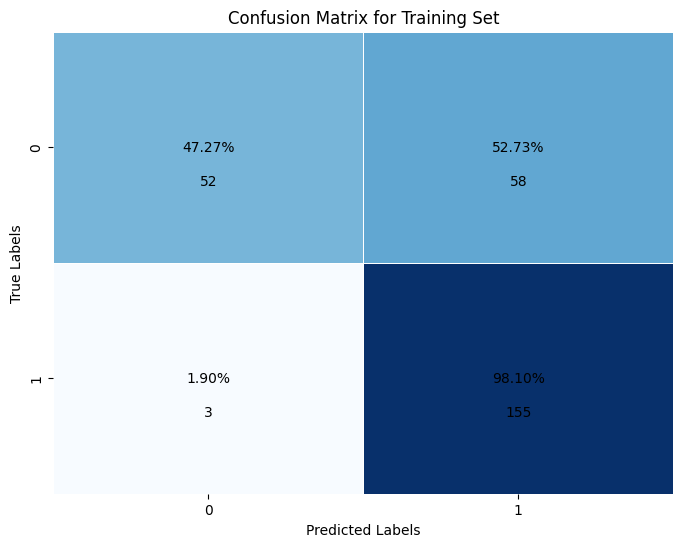

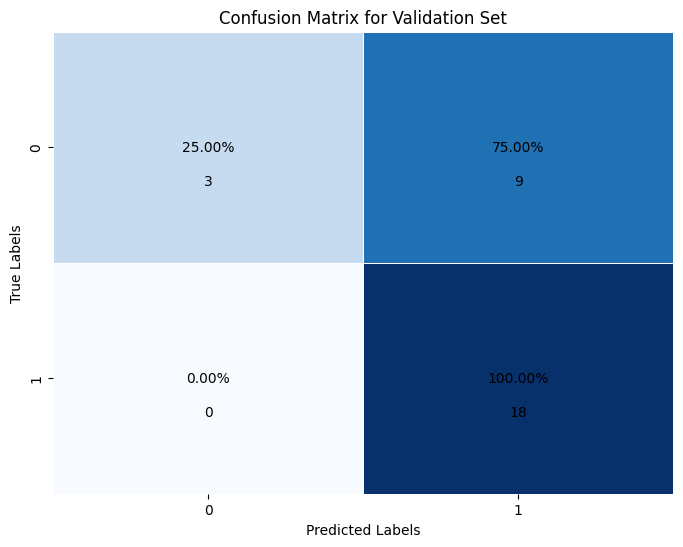

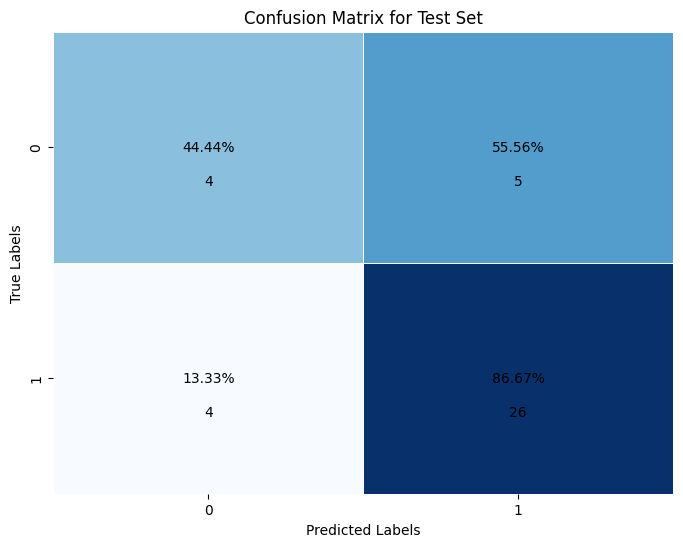

In [40]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

# <span style = "color : Orange"> Support Vector Machine </span>


###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [41]:

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]  # only relevant for 'poly' kernel
}

best_accuracy_diff = float('inf')
ecfp_best_params_svm = {}
results = []

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:
            if kernel == 'poly':
                for degree in param_grid['degree']:
                    svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree)
                    svm_classifier.fit(X_train, y_train)
                    y_pred_train = svm_classifier.predict(X_train)
                    y_pred_val = svm_classifier.predict(X_val)
                    y_pred_test = svm_classifier.predict(X_test)
                    
                    train_accuracy = accuracy_score(y_train, y_pred_train)
                    validation_accuracy = accuracy_score(y_val, y_pred_val)
                    test_accuracy = accuracy_score(y_test, y_pred_test)
                    accuracy_diff = abs(train_accuracy - test_accuracy)
                    
                    results.append({
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel,
                        'degree': degree,
                        'train_accuracy': train_accuracy,
                        'validation_accuracy': validation_accuracy,
                        'test_accuracy': test_accuracy,
                        'accuracy_diff': accuracy_diff
                    })
                    
                    if accuracy_diff < best_accuracy_diff:
                        best_accuracy_diff = accuracy_diff
                        ecfp_best_params_svm = {
                            'C': C,
                            'gamma': gamma,
                            'kernel': kernel,
                            'degree': degree
                        }
            else:
                svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel)
                svm_classifier.fit(X_train, y_train)
                y_pred_train = svm_classifier.predict(X_train)
                y_pred_val = svm_classifier.predict(X_val)
                y_pred_test = svm_classifier.predict(X_test)
                
                train_accuracy = accuracy_score(y_train, y_pred_train)
                validation_accuracy = accuracy_score(y_val, y_pred_val)
                test_accuracy = accuracy_score(y_test, y_pred_test)
                accuracy_diff = abs(train_accuracy - test_accuracy)
                
                results.append({
                    'C': C,
                    'gamma': gamma,
                    'kernel': kernel,
                    'train_accuracy': train_accuracy,
                    'validation_accuracy': validation_accuracy,
                    'test_accuracy': test_accuracy,
                    'accuracy_diff': accuracy_diff
                })
                
                if accuracy_diff < best_accuracy_diff:
                    best_accuracy_diff = accuracy_diff
                    ecfp_best_params_svm = {
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel
                    }

results_df = pd.DataFrame(results)
results_df.to_csv('svm_hyperparameter_tuning_ecfp.csv', index=False)

print("Best hyperparameters for SVM:")
print(ecfp_best_params_svm)

Best hyperparameters for SVM:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


###  <span style = "color : lightgreen"> Model Training with the best parameters || Validation || Model performance on Test set </span>

In [42]:
if ecfp_best_params_svm['kernel'] == 'poly':
    best_svm_classifier = SVC(**ecfp_best_params_svm)
else:
    ecfp_best_params_svm.pop('degree', None)
    best_svm_classifier = SVC(**ecfp_best_params_svm)

best_svm_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_svm_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_svm_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

# Model Performance on Test Set
y_pred_test = best_svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7910447761194029
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.7333333333333333
--------------------------------------------------------------------------
Confusion Matrix:
[[ 4  8]
 [ 0 18]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        12
           1       0.69      1.00      0.82        18

    accuracy                           0.73        30
   macro avg       0.85      0.67      0.66        30
weighted avg       0.82      0.73      0.69        30

--------------------------------------------------------------------------
-------------------------------------------

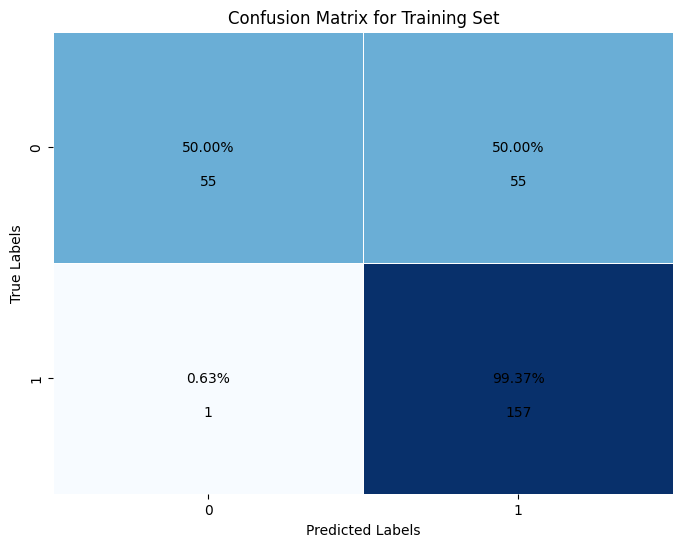

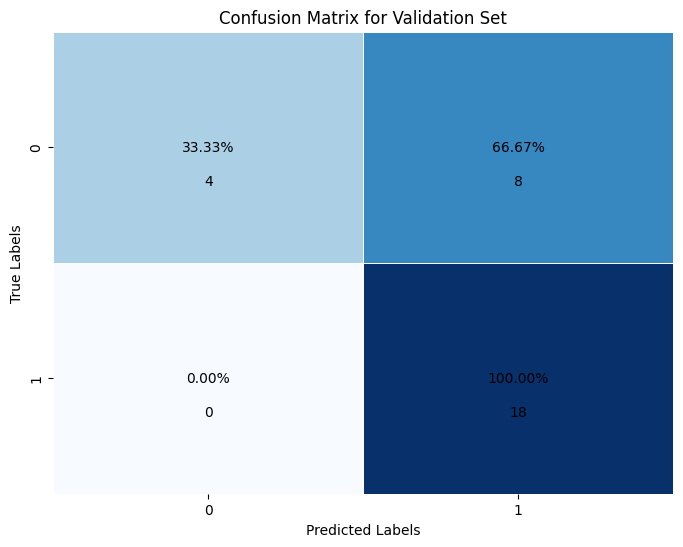

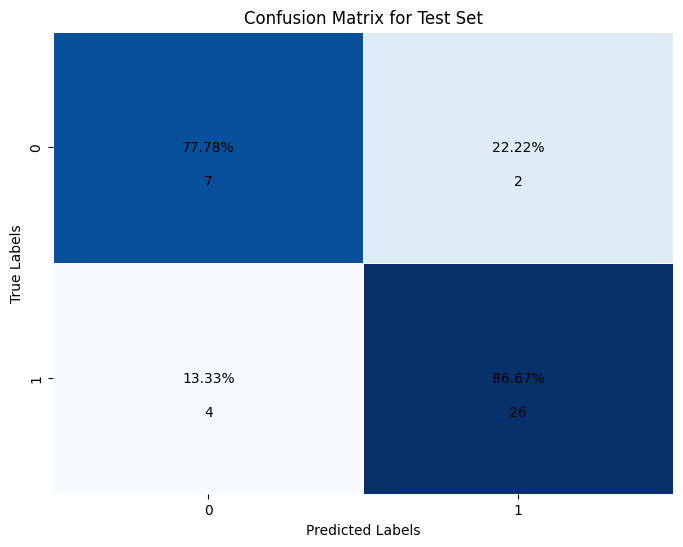

In [43]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

#  <span style = "color : red"> MACCS Keys Fingerprint </span>

In [44]:
def fingerprint_maccs_keys_smiles_list(
        smiles
):
    fingerprint_rep = [None] * len(smiles)

    for i, sm in enumerate(smiles):
        mol = Chem.MolFromSmiles(sm)
        if mol is not None:
            fingerprint_bin =  MACCSkeys.GenMACCSKeys(mol)
            fingerprint_rep[i] = fingerprint_bin.ToBitString()

    return fingerprint_rep

In [45]:
train_input_features_maccs_keys = fingerprint_maccs_keys_smiles_list(train_smile)
test_input_features_maccs_keys = fingerprint_maccs_keys_smiles_list(test_smile)

###  <span style = "color : lightgreen"> Making Train and Test Dataframe </span>

In [46]:
input_train_descriptor = []
for binary_string in train_input_features_maccs_keys:
    output_list = [int(bit) for bit in binary_string]
    input_train_descriptor.append(output_list)
train_descriptor_frame_maccs_keys = pd.DataFrame(input_train_descriptor)
train_descriptor_frame_maccs_keys.columns = [f'descriptor_{i+1}' for i in range(167)]
train_descriptor_frame_maccs_keys['class'] = df_train['logBB_class']
train_descriptor_frame_maccs_keys

,descriptor_1,descriptor_2,descriptor_3,descriptor_4,descriptor_5,descriptor_6,descriptor_7,descriptor_8,descriptor_9,descriptor_10,...,descriptor_159,descriptor_160,descriptor_161,descriptor_162,descriptor_163,descriptor_164,descriptor_165,descriptor_166,descriptor_167,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,0
294,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,1,0,0
295,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
296,0,0,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,0,0


In [47]:
input_test_descriptor = []
for binary_string in test_input_features_maccs_keys:
    output_list = [int(bit) for bit in binary_string]
    input_test_descriptor.append(output_list)
test_descriptor_frame_maccs_keys = pd.DataFrame(input_test_descriptor)
test_descriptor_frame_maccs_keys.columns = [f'descriptor_{i+1}' for i in range(167)]
test_descriptor_frame_maccs_keys['class'] = df_test['p_np']
test_descriptor_frame_maccs_keys

,descriptor_1,descriptor_2,descriptor_3,descriptor_4,descriptor_5,descriptor_6,descriptor_7,descriptor_8,descriptor_9,descriptor_10,...,descriptor_159,descriptor_160,descriptor_161,descriptor_162,descriptor_163,descriptor_164,descriptor_165,descriptor_166,descriptor_167,class
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
5,0,0,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,1,0,1
7,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
8,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,1
9,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,1,1,1,0,1


##  <span style = "color : lightgreen"> Splitting into Train and Validation Set </span>

In [48]:
X = train_descriptor_frame_maccs_keys.drop(columns='class')
y = train_descriptor_frame_maccs_keys['class']
class_0 = train_descriptor_frame_maccs_keys[train_descriptor_frame_maccs_keys['class'] == 0]
class_1 = train_descriptor_frame_maccs_keys[train_descriptor_frame_maccs_keys['class'] == 1]

class_0_val = class_0.sample(frac=0.1, random_state=42)
class_1_val = class_1.sample(frac=0.1, random_state=42)

validation_set = pd.concat([class_0_val, class_1_val])

class_0_train = class_0.drop(class_0_val.index)
class_1_train = class_1.drop(class_1_val.index)

training_set = pd.concat([class_0_train, class_1_train])

X_train = training_set.drop(columns='class')
y_train = training_set['class']
X_val = validation_set.drop(columns='class')
y_val = validation_set['class']

validation_set = validation_set.reset_index().rename(columns={'index': 'index'})

validation_set.to_csv('validation_set_maccs_keys.csv', index=False)

print("Training set distribution:")
print(training_set['class'].value_counts())
print("Validation set distribution:")
print(validation_set['class'].value_counts())


X_test = test_descriptor_frame_maccs_keys.drop(columns='class')
y_test = test_descriptor_frame_maccs_keys['class']

Training set distribution:
class
1    158
0    110
Name: count, dtype: int64
Validation set distribution:
class
1    18
0    12
Name: count, dtype: int64


##  <span style = "color : Orange"> Random Forest </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [49]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 15],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

best_accuracy_diff = float('inf')
maccs_keys_best_params_rf = {}
results = []

for n_estimators in param_grid['n_estimators']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                for bootstrap in param_grid['bootstrap']:
                    for criterion in param_grid['criterion']:
                        for max_features in param_grid['max_features']:
                            rf_classifier = RandomForestClassifier(
                                n_estimators=n_estimators,
                                min_samples_leaf=min_samples_leaf,
                                bootstrap=bootstrap,
                                criterion=criterion,
                                max_features=max_features,
                                random_state=42
                            )
                            rf_classifier.fit(X_train, y_train)
                            y_pred_train = rf_classifier.predict(X_train)
                            y_pred_val = rf_classifier.predict(X_val)
                            y_pred_test = rf_classifier.predict(X_test)
                            
                            train_accuracy = accuracy_score(y_train, y_pred_train)
                            validation_accuracy = accuracy_score(y_val, y_pred_val)
                            test_accuracy = accuracy_score(y_test, y_pred_test)
                            accuracy_diff = abs(train_accuracy - test_accuracy)
                            
                            results.append({
                                'n_estimators': n_estimators,
                                'min_samples_leaf': min_samples_leaf,
                                'bootstrap': bootstrap,
                                'criterion': criterion,
                                'max_features': max_features,
                                'train_accuracy': train_accuracy,
                                'validation_accuracy': validation_accuracy,
                                'test_accuracy': test_accuracy,
                                'accuracy_diff': accuracy_diff
                            })
                            
                            if accuracy_diff < best_accuracy_diff:
                                best_accuracy_diff = accuracy_diff
                                maccs_keys_best_params_rf = {
                                    'n_estimators': n_estimators,
                                    'min_samples_leaf': min_samples_leaf,
                                    'bootstrap': bootstrap,
                                    'criterion': criterion,
                                    'max_features': max_features,
                                }

results_df = pd.DataFrame(results)
results_df.to_csv('rf_hyperparameter_tuning_maccs_keys.csv', index=False)

print("Best hyperparameters for Random Forest:")
print(maccs_keys_best_params_rf)



Best hyperparameters for Random Forest:
{'n_estimators': 100, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2'}


###  <span style = "color : lightgreen"> Model Training with the best parameters and Validation </span>

In [50]:
best_rf_classifier = RandomForestClassifier(**maccs_keys_best_params_rf, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_rf_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7798507462686567
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.7
--------------------------------------------------------------------------
Confusion Matrix:
[[ 5  7]
 [ 2 16]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.42      0.53        12
           1       0.70      0.89      0.78        18

    accuracy                           0.70        30
   macro avg       0.70      0.65      0.65        30
weighted avg       0.70      0.70      0.68        30

--------------------------------------------------------------------------


###  <span style = "color : lightgreen"> Model Performance on Test Set </span>

In [51]:
y_pred_test = best_rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Test Accuracy with best parameters:
0.6923076923076923
--------------------------------------------------------------------------
Confusion Matrix:
[[ 7  2]
 [10 20]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.78      0.54         9
           1       0.91      0.67      0.77        30

    accuracy                           0.69        39
   macro avg       0.66      0.72      0.65        39
weighted avg       0.79      0.69      0.72        39

--------------------------------------------------------------------------


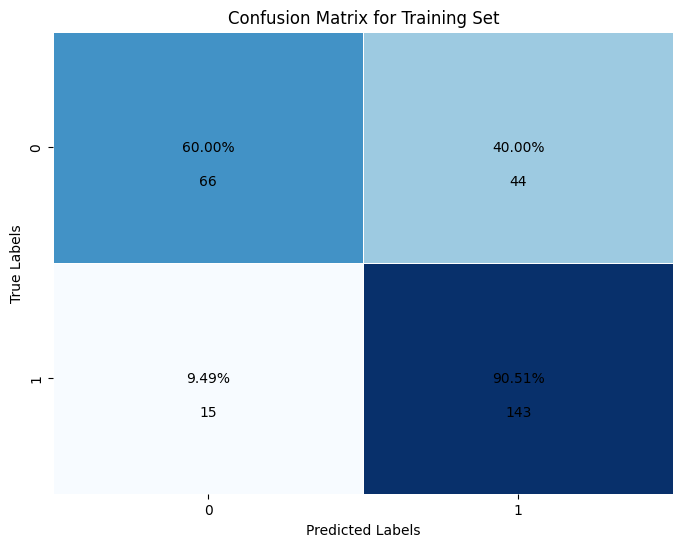

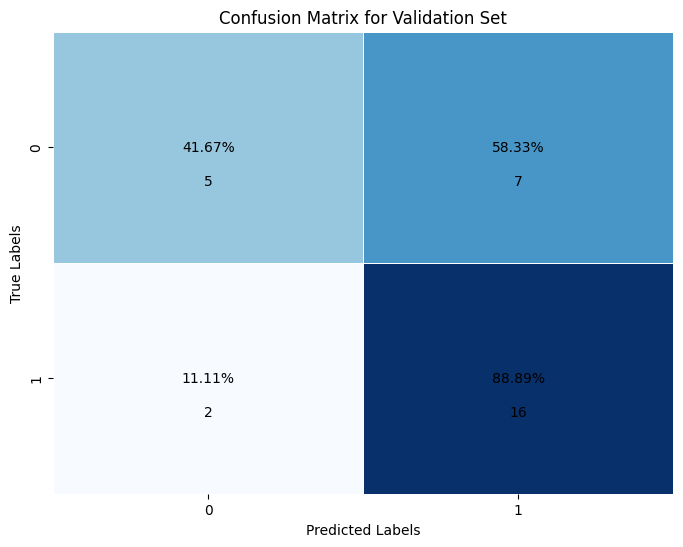

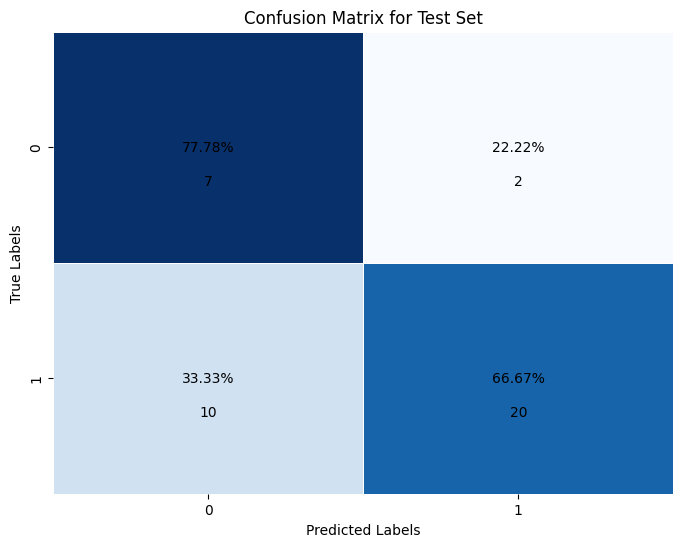

In [52]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

##  <span style = "color : Orange"> Support Vector Machine </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [53]:

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]  # only relevant for 'poly' kernel
}

best_accuracy_diff = float('inf')
maccs_keys_best_params_svm = {}
results = []

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:
            if kernel == 'poly':
                for degree in param_grid['degree']:
                    svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree)
                    svm_classifier.fit(X_train, y_train)
                    y_pred_train = svm_classifier.predict(X_train)
                    y_pred_val = svm_classifier.predict(X_val)
                    y_pred_test = svm_classifier.predict(X_test)
                    
                    train_accuracy = accuracy_score(y_train, y_pred_train)
                    validation_accuracy = accuracy_score(y_val, y_pred_val)
                    test_accuracy = accuracy_score(y_test, y_pred_test)
                    accuracy_diff = abs(train_accuracy - test_accuracy)
                    
                    results.append({
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel,
                        'degree': degree,
                        'train_accuracy': train_accuracy,
                        'validation_accuracy': validation_accuracy,
                        'test_accuracy': test_accuracy,
                        'accuracy_diff': accuracy_diff
                    })
                    
                    if accuracy_diff < best_accuracy_diff:
                        best_accuracy_diff = accuracy_diff
                        maccs_keys_best_params_svm = {
                            'C': C,
                            'gamma': gamma,
                            'kernel': kernel,
                            'degree': degree
                        }
            else:
                svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel)
                svm_classifier.fit(X_train, y_train)
                y_pred_train = svm_classifier.predict(X_train)
                y_pred_val = svm_classifier.predict(X_val)
                y_pred_test = svm_classifier.predict(X_test)
                
                train_accuracy = accuracy_score(y_train, y_pred_train)
                validation_accuracy = accuracy_score(y_val, y_pred_val)
                test_accuracy = accuracy_score(y_test, y_pred_test)
                accuracy_diff = abs(train_accuracy - test_accuracy)
                
                results.append({
                    'C': C,
                    'gamma': gamma,
                    'kernel': kernel,
                    'train_accuracy': train_accuracy,
                    'validation_accuracy': validation_accuracy,
                    'test_accuracy': test_accuracy,
                    'accuracy_diff': accuracy_diff
                })
                
                if accuracy_diff < best_accuracy_diff:
                    best_accuracy_diff = accuracy_diff
                    maccs_keys_best_params_svm = {
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel
                    }

results_df = pd.DataFrame(results)
results_df.to_csv('svm_hyperparameter_tuning_maccs_keys.csv', index=False)

print("Best hyperparameters for SVM:")
print(maccs_keys_best_params_svm)

Best hyperparameters for SVM:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'degree': 3}


###  <span style = "color : lightgreen"> Model Training with the best parameters and Validation </span>

In [54]:
if maccs_keys_best_params_svm['kernel'] == 'poly':
    best_svm_classifier = SVC(**maccs_keys_best_params_svm)
else:
    maccs_keys_best_params_svm.pop('degree', None)
    best_svm_classifier = SVC(**maccs_keys_best_params_svm)

best_svm_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_svm_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_svm_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")


--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7686567164179104
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.7333333333333333
--------------------------------------------------------------------------
Confusion Matrix:
[[ 4  8]
 [ 0 18]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        12
           1       0.69      1.00      0.82        18

    accuracy                           0.73        30
   macro avg       0.85      0.67      0.66        30
weighted avg       0.82      0.73      0.69        30

--------------------------------------------------------------------------


###  <span style = "color : lightgreen"> Model Performance on Test Set </span>

In [55]:
X_test = test_descriptor_frame_maccs_keys.drop(columns='class')
y_test = test_descriptor_frame_maccs_keys['class']
y_pred_test = best_svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Test Accuracy with best parameters:
0.7692307692307693
--------------------------------------------------------------------------
Confusion Matrix:
[[ 6  3]
 [ 6 24]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         9
           1       0.89      0.80      0.84        30

    accuracy                           0.77        39
   macro avg       0.69      0.73      0.71        39
weighted avg       0.80      0.77      0.78        39

--------------------------------------------------------------------------


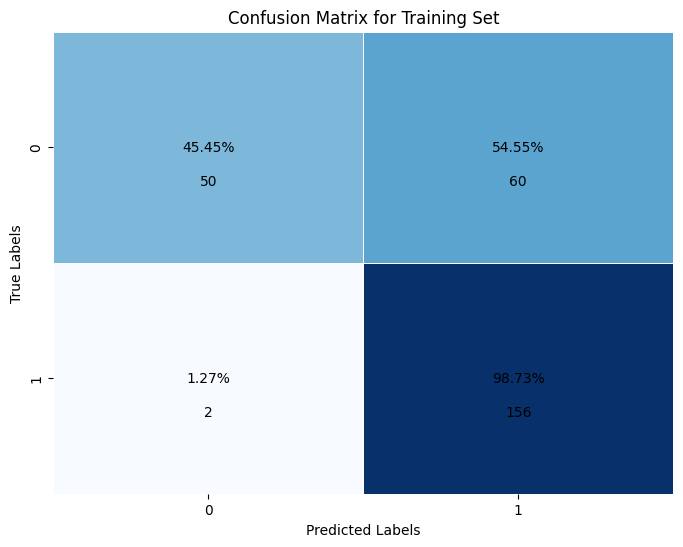

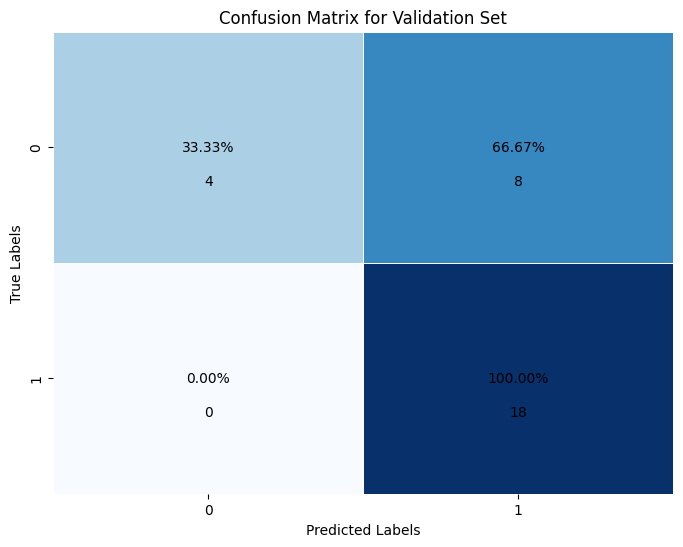

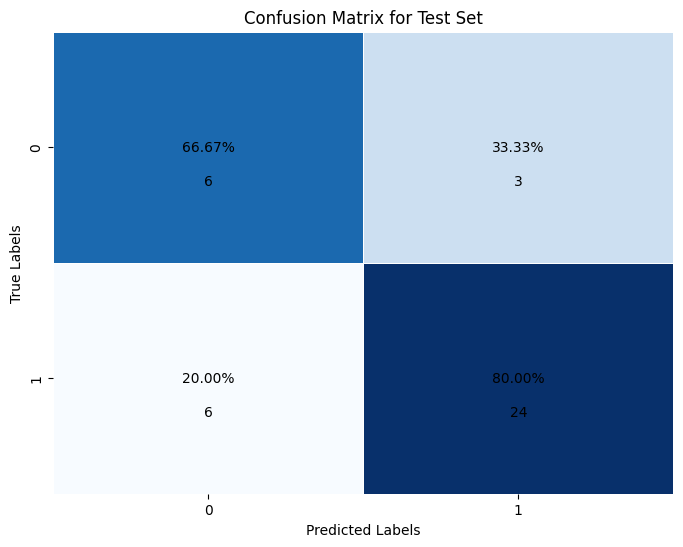

In [56]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

#  <span style = "color : red"> Morgan Fingerprint </span>

In [57]:
def fingerprint_morgan_smiles_list(
        smiles,
        radius = 1,
        len_fingerprint=2048,
        from_atoms=0,
        atom_invariants=0,
        Chirality=False,
        Bond_Types=True,
        use_Features=False,
        bitInfo=None,
        RedundantEnvironments=False
):
    fingerprint_rep = [None] * len(smiles)

    for i, sm in enumerate(smiles):
        mol = Chem.MolFromSmiles(sm)
        if mol is not None:
            fingerprint_bin = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=len_fingerprint, 
                                                                invariants=atom_invariants, fromAtoms=from_atoms,
                                                                useChirality=Chirality, useBondTypes=Bond_Types,
                                                                useFeatures=use_Features, bitInfo=bitInfo,
                                                                 includeRedundantEnvironments=RedundantEnvironments ) 
            fingerprint_rep[i] = fingerprint_bin.ToBitString()

    return fingerprint_rep 


In [58]:
train_input_features_morgan = fingerprint_morgan_smiles_list(train_smile)
test_input_features_morgan = fingerprint_morgan_smiles_list(test_smile)

###  <span style = "color : lightgreen"> Making Train and Test Dataframe </span>

In [59]:
input_train_descriptor = []
for binary_string in train_input_features_morgan:
    output_list = [int(bit) for bit in binary_string]
    input_train_descriptor.append(output_list)
train_descriptor_frame_morgan = pd.DataFrame(input_train_descriptor)
train_descriptor_frame_morgan.columns = [f'descriptor_{i+1}' for i in range(2048)]
train_descriptor_frame_morgan['class'] = df_train['logBB_class']
train_descriptor_frame_morgan

,descriptor_1,descriptor_2,descriptor_3,descriptor_4,descriptor_5,descriptor_6,descriptor_7,descriptor_8,descriptor_9,descriptor_10,...,descriptor_2040,descriptor_2041,descriptor_2042,descriptor_2043,descriptor_2044,descriptor_2045,descriptor_2046,descriptor_2047,descriptor_2048,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
296,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
input_test_descriptor = []
for binary_string in test_input_features_morgan:
    output_list = [int(bit) for bit in binary_string]
    input_test_descriptor.append(output_list)
test_descriptor_frame_morgan = pd.DataFrame(input_test_descriptor)
test_descriptor_frame_morgan.columns = [f'descriptor_{i+1}' for i in range(2048)]
test_descriptor_frame_morgan['class'] = df_test['p_np']
test_descriptor_frame_morgan

,descriptor_1,descriptor_2,descriptor_3,descriptor_4,descriptor_5,descriptor_6,descriptor_7,descriptor_8,descriptor_9,descriptor_10,...,descriptor_2040,descriptor_2041,descriptor_2042,descriptor_2043,descriptor_2044,descriptor_2045,descriptor_2046,descriptor_2047,descriptor_2048,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


##  <span style = "color : lightgreen"> Splitting into Train and Validation Set </span>

In [61]:
X = train_descriptor_frame_morgan.drop(columns='class')
y = train_descriptor_frame_morgan['class']
class_0 = train_descriptor_frame_morgan[train_descriptor_frame_morgan['class'] == 0]
class_1 = train_descriptor_frame_morgan[train_descriptor_frame_morgan['class'] == 1]

class_0_val = class_0.sample(frac=0.1, random_state=42)
class_1_val = class_1.sample(frac=0.1, random_state=42)

validation_set = pd.concat([class_0_val, class_1_val])

class_0_train = class_0.drop(class_0_val.index)
class_1_train = class_1.drop(class_1_val.index)

training_set = pd.concat([class_0_train, class_1_train])

X_train = training_set.drop(columns='class')
y_train = training_set['class']
X_val = validation_set.drop(columns='class')
y_val = validation_set['class']

validation_set = validation_set.reset_index().rename(columns={'index': 'index'})

validation_set.to_csv('validation_set_morgan.csv', index=False)

print("Training set distribution:")
print(training_set['class'].value_counts())
print("Validation set distribution:")
print(validation_set['class'].value_counts())

X_test = test_descriptor_frame_morgan.drop(columns='class')
y_test = test_descriptor_frame_morgan['class']


Training set distribution:
class
1    158
0    110
Name: count, dtype: int64
Validation set distribution:
class
1    18
0    12
Name: count, dtype: int64


##  <span style = "color : Orange"> Random Forest </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [62]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 15],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

best_accuracy_diff = float('inf')
morgan_best_params_rf = {}
results = []

for n_estimators in param_grid['n_estimators']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                for bootstrap in param_grid['bootstrap']:
                    for criterion in param_grid['criterion']:
                        for max_features in param_grid['max_features']:
                            rf_classifier = RandomForestClassifier(
                                n_estimators=n_estimators,
                                min_samples_leaf=min_samples_leaf,
                                bootstrap=bootstrap,
                                criterion=criterion,
                                max_features=max_features,
                                random_state=42
                            )
                            rf_classifier.fit(X_train, y_train)
                            y_pred_train = rf_classifier.predict(X_train)
                            y_pred_val = rf_classifier.predict(X_val)
                            y_pred_test = rf_classifier.predict(X_test)
                            
                            train_accuracy = accuracy_score(y_train, y_pred_train)
                            validation_accuracy = accuracy_score(y_val, y_pred_val)
                            test_accuracy = accuracy_score(y_test, y_pred_test)
                            accuracy_diff = abs(train_accuracy - test_accuracy)
                            
                            results.append({
                                'n_estimators': n_estimators,
                                'min_samples_leaf': min_samples_leaf,
                                'bootstrap': bootstrap,
                                'criterion': criterion,
                                'max_features': max_features,
                                'train_accuracy': train_accuracy,
                                'validation_accuracy': validation_accuracy,
                                'test_accuracy': test_accuracy,
                                'accuracy_diff': accuracy_diff
                            })
                            
                            if accuracy_diff < best_accuracy_diff:
                                best_accuracy_diff = accuracy_diff
                                morgan_best_params_rf = {
                                    'n_estimators': n_estimators,
                                    'min_samples_leaf': min_samples_leaf,
                                    'bootstrap': bootstrap,
                                    'criterion': criterion,
                                    'max_features': max_features,
                                }

results_df = pd.DataFrame(results)
results_df.to_csv('rf_hyperparameter_tuning_morgan.csv', index=False)

print("Best hyperparameters for Random Forest:")
print(morgan_best_params_rf)



Best hyperparameters for Random Forest:
{'n_estimators': 50, 'min_samples_leaf': 8, 'bootstrap': False, 'criterion': 'entropy', 'max_features': 'sqrt'}


###  <span style = "color : lightgreen"> Model Training with the best parameters and Validation </span>

In [63]:
best_rf_classifier = RandomForestClassifier(**morgan_best_params_rf, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_rf_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7649253731343284
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.7333333333333333
--------------------------------------------------------------------------
Confusion Matrix:
[[ 5  7]
 [ 1 17]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.42      0.56        12
           1       0.71      0.94      0.81        18

    accuracy                           0.73        30
   macro avg       0.77      0.68      0.68        30
weighted avg       0.76      0.73      0.71        30

--------------------------------------------------------------------------


###  <span style = "color : lightgreen"> Model Performance on Test Set </span>

In [64]:
X_test = test_descriptor_frame_morgan.drop(columns='class')
y_test = test_descriptor_frame_morgan['class']
y_pred_test = best_rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Test Accuracy with best parameters:
0.7692307692307693
--------------------------------------------------------------------------
Confusion Matrix:
[[ 8  1]
 [ 8 22]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.89      0.64         9
           1       0.96      0.73      0.83        30

    accuracy                           0.77        39
   macro avg       0.73      0.81      0.74        39
weighted avg       0.85      0.77      0.79        39

--------------------------------------------------------------------------


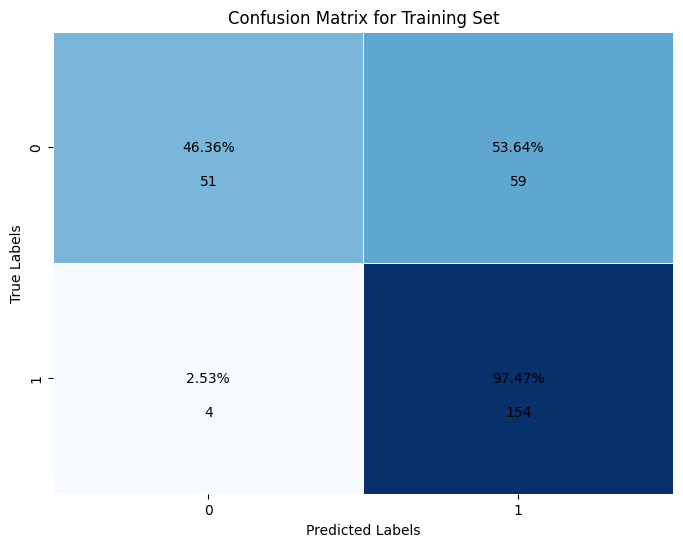

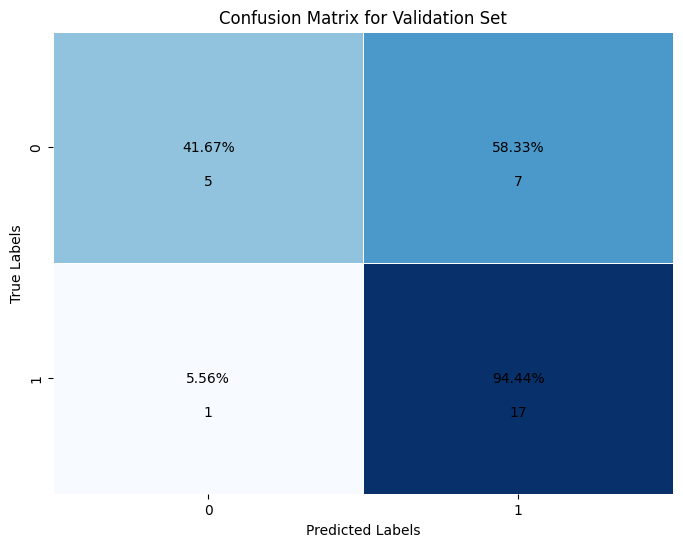

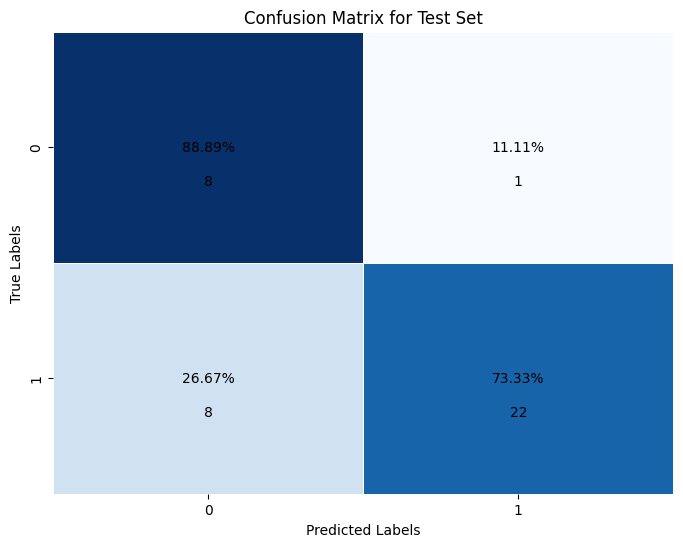

In [65]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

##  <span style = "color : Orange"> Support Vector Machine </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [66]:

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]  # only relevant for 'poly' kernel
}

best_accuracy_diff = float('inf')
morgan_best_params_svm = {}
results = []

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:
            if kernel == 'poly':
                for degree in param_grid['degree']:
                    svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree)
                    svm_classifier.fit(X_train, y_train)
                    y_pred_train = svm_classifier.predict(X_train)
                    y_pred_val = svm_classifier.predict(X_val)
                    y_pred_test = svm_classifier.predict(X_test)
                    
                    train_accuracy = accuracy_score(y_train, y_pred_train)
                    validation_accuracy = accuracy_score(y_val, y_pred_val)
                    test_accuracy = accuracy_score(y_test, y_pred_test)
                    accuracy_diff = abs(train_accuracy - test_accuracy)
                    
                    results.append({
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel,
                        'degree': degree,
                        'train_accuracy': train_accuracy,
                        'validation_accuracy': validation_accuracy,
                        'test_accuracy': test_accuracy,
                        'accuracy_diff': accuracy_diff
                    })
                    
                    if accuracy_diff < best_accuracy_diff:
                        best_accuracy_diff = accuracy_diff
                        morgan_best_params_svm = {
                            'C': C,
                            'gamma': gamma,
                            'kernel': kernel,
                            'degree': degree
                        }
            else:
                svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel)
                svm_classifier.fit(X_train, y_train)
                y_pred_train = svm_classifier.predict(X_train)
                y_pred_val = svm_classifier.predict(X_val)
                y_pred_test = svm_classifier.predict(X_test)
                
                train_accuracy = accuracy_score(y_train, y_pred_train)
                validation_accuracy = accuracy_score(y_val, y_pred_val)
                test_accuracy = accuracy_score(y_test, y_pred_test)
                accuracy_diff = abs(train_accuracy - test_accuracy)
                
                results.append({
                    'C': C,
                    'gamma': gamma,
                    'kernel': kernel,
                    'train_accuracy': train_accuracy,
                    'validation_accuracy': validation_accuracy,
                    'test_accuracy': test_accuracy,
                    'accuracy_diff': accuracy_diff
                })
                
                if accuracy_diff < best_accuracy_diff:
                    best_accuracy_diff = accuracy_diff
                    morgan_best_params_svm = {
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel
                    }

results_df = pd.DataFrame(results)
results_df.to_csv('svm_hyperparameter_tuning_morgan.csv', index=False)

print("Best hyperparameters for SVM:")
print(morgan_best_params_svm)

Best hyperparameters for SVM:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


###  <span style = "color : lightgreen"> Model Training with the best parameters and Validation </span>

In [67]:
if morgan_best_params_svm['kernel'] == 'poly':
    best_svm_classifier = SVC(**morgan_best_params_svm)
else:
    morgan_best_params_svm.pop('degree', None)
    best_svm_classifier = SVC(**morgan_best_params_svm)

best_svm_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_svm_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_svm_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")


--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7574626865671642
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.7333333333333333
--------------------------------------------------------------------------
Confusion Matrix:
[[ 4  8]
 [ 0 18]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        12
           1       0.69      1.00      0.82        18

    accuracy                           0.73        30
   macro avg       0.85      0.67      0.66        30
weighted avg       0.82      0.73      0.69        30

--------------------------------------------------------------------------


###  <span style = "color : lightgreen"> Model Performance on Test Set </span>

In [68]:
y_pred_test = best_svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Test Accuracy with best parameters:
0.8205128205128205
--------------------------------------------------------------------------
Confusion Matrix:
[[ 7  2]
 [ 5 25]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.78      0.67         9
           1       0.93      0.83      0.88        30

    accuracy                           0.82        39
   macro avg       0.75      0.81      0.77        39
weighted avg       0.85      0.82      0.83        39

--------------------------------------------------------------------------


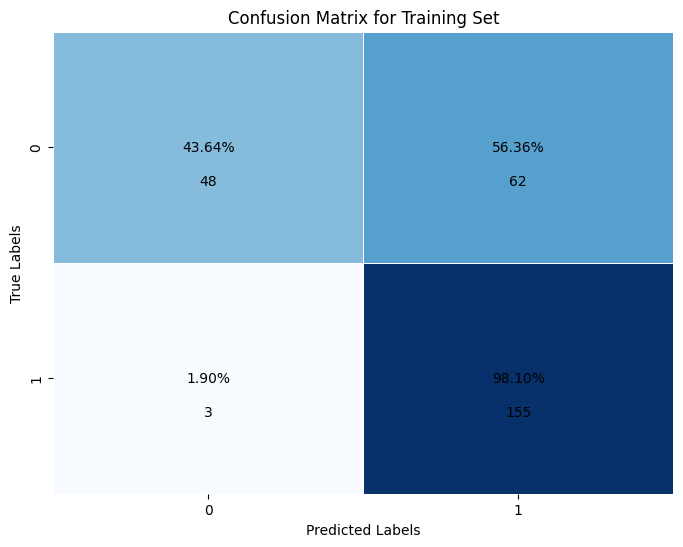

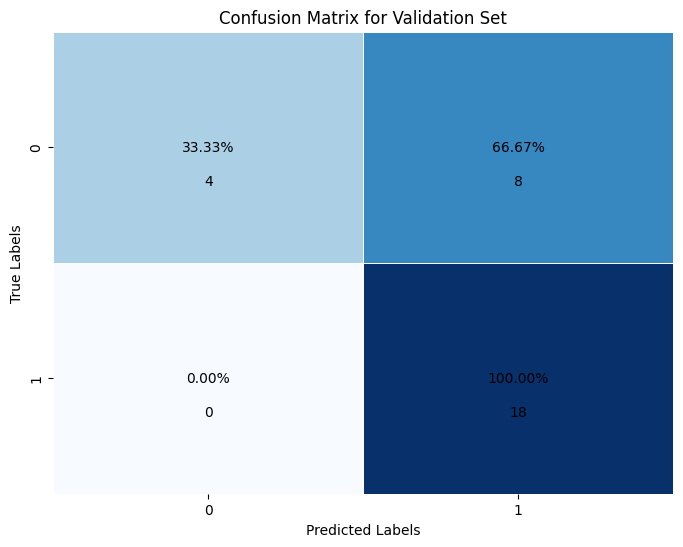

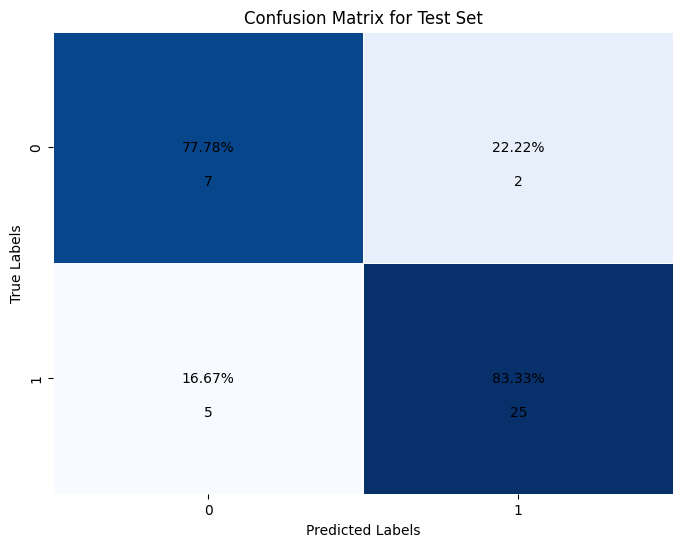

In [69]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

#  <span style = "color : red"> Pharmacophore Fingerprint </span>

In [70]:
def fingerprint_pharmacophore_smiles_list(smiles_list):
    fingerprint_rep = [None] * len(smiles_list)
    for i,smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        AllChem.Compute2DCoords(mol)
        featFactory = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))
        if featFactory.GetFeaturesForMol(mol) == []:
            return None  
        sigFactory = SigFactory(featFactory)
        sigFactory.SetBins([(0,3), (3,6), (6,10)]) 
        sigFactory.Init()
        pharm2d = Generate.Gen2DFingerprint(mol, sigFactory)
        fingerprint_rep[i]=pharm2d.ToBitString()
    return fingerprint_rep

In [71]:
train_input_features_pharmacophore = fingerprint_pharmacophore_smiles_list(train_smile)
test_input_features_pharmacophore = fingerprint_pharmacophore_smiles_list(test_smile)

###  <span style = "color : lightgreen"> Making Train and Test Dataframe </span>

In [72]:
input_train_descriptor = []
for binary_string in train_input_features_pharmacophore:
    output_list = [int(bit) for bit in binary_string]
    input_train_descriptor.append(output_list)
train_descriptor_frame_pharmacophore = pd.DataFrame(input_train_descriptor)
train_descriptor_frame_pharmacophore.columns = [f'descriptor_{i+1}' for i in range(3348)]
train_descriptor_frame_pharmacophore['class'] = df_train['logBB_class']
train_descriptor_frame_pharmacophore

,descriptor_1,descriptor_2,descriptor_3,descriptor_4,descriptor_5,descriptor_6,descriptor_7,descriptor_8,descriptor_9,descriptor_10,...,descriptor_3340,descriptor_3341,descriptor_3342,descriptor_3343,descriptor_3344,descriptor_3345,descriptor_3346,descriptor_3347,descriptor_3348,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
294,1,0,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
295,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
296,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [73]:
input_test_descriptor = []
for binary_string in test_input_features_pharmacophore:
    output_list = [int(bit) for bit in binary_string]
    input_test_descriptor.append(output_list)
test_descriptor_frame_pharmacophore = pd.DataFrame(input_test_descriptor)
test_descriptor_frame_pharmacophore.columns = [f'descriptor_{i+1}' for i in range(3348)]
test_descriptor_frame_pharmacophore['class'] = df_test['p_np']
test_descriptor_frame_pharmacophore

,descriptor_1,descriptor_2,descriptor_3,descriptor_4,descriptor_5,descriptor_6,descriptor_7,descriptor_8,descriptor_9,descriptor_10,...,descriptor_3340,descriptor_3341,descriptor_3342,descriptor_3343,descriptor_3344,descriptor_3345,descriptor_3346,descriptor_3347,descriptor_3348,class
0,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
7,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
9,0,1,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1


##  <span style = "color : lightgreen"> Splitting into Train and Validation Set </span>

In [74]:
X = train_descriptor_frame_pharmacophore.drop(columns='class')
y = train_descriptor_frame_pharmacophore['class']
class_0 = train_descriptor_frame_pharmacophore[train_descriptor_frame_pharmacophore['class'] == 0]
class_1 = train_descriptor_frame_pharmacophore[train_descriptor_frame_pharmacophore['class'] == 1]

class_0_val = class_0.sample(frac=0.1, random_state=42)
class_1_val = class_1.sample(frac=0.1, random_state=42)

validation_set = pd.concat([class_0_val, class_1_val])

class_0_train = class_0.drop(class_0_val.index)
class_1_train = class_1.drop(class_1_val.index)

training_set = pd.concat([class_0_train, class_1_train])

X_train = training_set.drop(columns='class')
y_train = training_set['class']
X_val = validation_set.drop(columns='class')
y_val = validation_set['class']

validation_set = validation_set.reset_index().rename(columns={'index': 'index'})

validation_set.to_csv('validation_set_pharmacophore.csv', index=False)

print("Training set distribution:")
print(training_set['class'].value_counts())
print("Validation set distribution:")
print(validation_set['class'].value_counts())

X_test = test_descriptor_frame_pharmacophore.drop(columns='class')
y_test = test_descriptor_frame_pharmacophore['class']


Training set distribution:
class
1    158
0    110
Name: count, dtype: int64
Validation set distribution:
class
1    18
0    12
Name: count, dtype: int64


##  <span style = "color : Orange"> Random Forest </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [75]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 15],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

best_accuracy_diff = float('inf')
pharmacophore_best_params_rf = {}
results = []

for n_estimators in param_grid['n_estimators']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                for bootstrap in param_grid['bootstrap']:
                    for criterion in param_grid['criterion']:
                        for max_features in param_grid['max_features']:
                            rf_classifier = RandomForestClassifier(
                                n_estimators=n_estimators,
                                min_samples_leaf=min_samples_leaf,
                                bootstrap=bootstrap,
                                criterion=criterion,
                                max_features=max_features,
                                random_state=42
                            )
                            rf_classifier.fit(X_train, y_train)
                            y_pred_train = rf_classifier.predict(X_train)
                            y_pred_val = rf_classifier.predict(X_val)
                            y_pred_test = rf_classifier.predict(X_test)
                            
                            train_accuracy = accuracy_score(y_train, y_pred_train)
                            validation_accuracy = accuracy_score(y_val, y_pred_val)
                            test_accuracy = accuracy_score(y_test, y_pred_test)
                            accuracy_diff = abs(train_accuracy - test_accuracy)
                            
                            results.append({
                                'n_estimators': n_estimators,
                                'min_samples_leaf': min_samples_leaf,
                                'bootstrap': bootstrap,
                                'criterion': criterion,
                                'max_features': max_features,
                                'train_accuracy': train_accuracy,
                                'validation_accuracy': validation_accuracy,
                                'test_accuracy': test_accuracy,
                                'accuracy_diff': accuracy_diff
                            })
                            
                            if accuracy_diff < best_accuracy_diff:
                                best_accuracy_diff = accuracy_diff
                                pharmacophore_best_params_rf = {
                                    'n_estimators': n_estimators,
                                    'min_samples_leaf': min_samples_leaf,
                                    'bootstrap': bootstrap,
                                    'criterion': criterion,
                                    'max_features': max_features,
                                }

results_df = pd.DataFrame(results)
results_df.to_csv('rf_hyperparameter_tuning_pharmacophore.csv', index=False)

print("Best hyperparameters for Random Forest:")
print(pharmacophore_best_params_rf)



Best hyperparameters for Random Forest:
{'n_estimators': 50, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt'}


###  <span style = "color : lightgreen"> Model Training with the best parameters and Validation </span>

In [76]:
best_rf_classifier = RandomForestClassifier(**pharmacophore_best_params_rf, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_rf_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7164179104477612
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.7333333333333333
--------------------------------------------------------------------------
Confusion Matrix:
[[ 5  7]
 [ 1 17]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.42      0.56        12
           1       0.71      0.94      0.81        18

    accuracy                           0.73        30
   macro avg       0.77      0.68      0.68        30
weighted avg       0.76      0.73      0.71        30

--------------------------------------------------------------------------


###  <span style = "color : lightgreen"> Model Performance on Test Set </span>

In [77]:
X_test = test_descriptor_frame_pharmacophore.drop(columns='class')
y_test = test_descriptor_frame_pharmacophore['class']
y_pred_test = best_rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Test Accuracy with best parameters:
0.717948717948718
--------------------------------------------------------------------------
Confusion Matrix:
[[ 7  2]
 [ 9 21]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.78      0.56         9
           1       0.91      0.70      0.79        30

    accuracy                           0.72        39
   macro avg       0.68      0.74      0.68        39
weighted avg       0.80      0.72      0.74        39

--------------------------------------------------------------------------


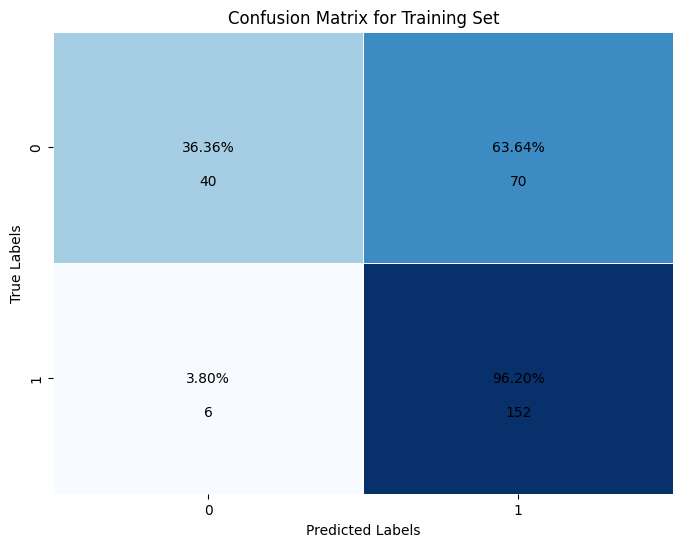

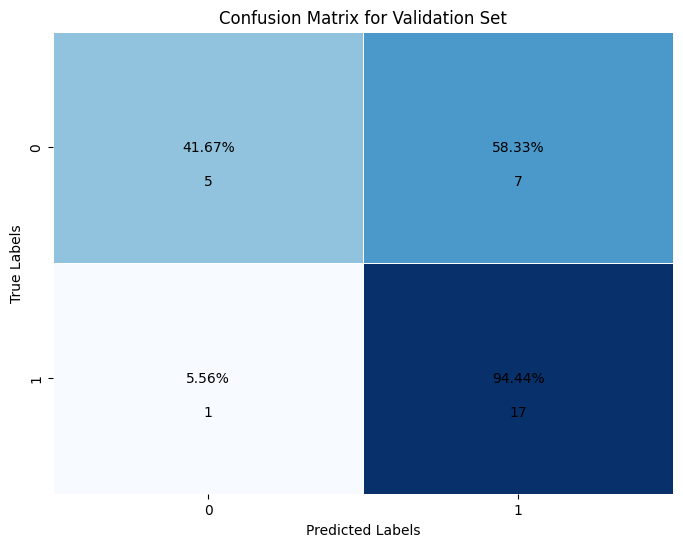

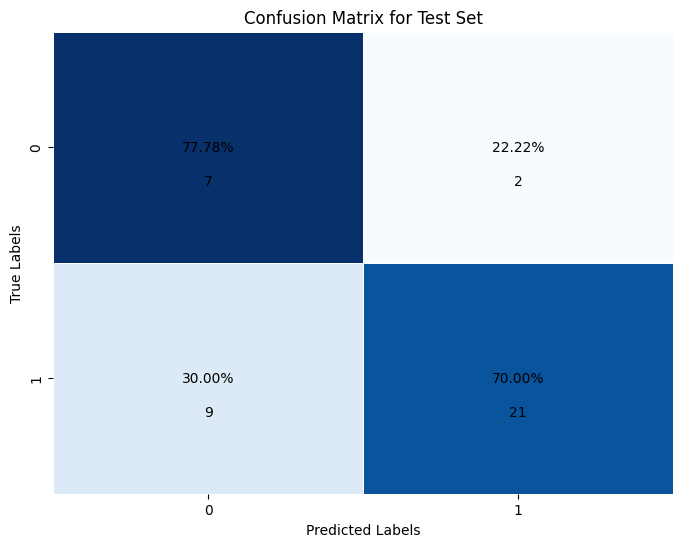

In [78]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

##  <span style = "color : Orange"> Support Vector Machine </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [79]:

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]  # only relevant for 'poly' kernel
}

best_accuracy_diff = float('inf')
pharmacophore_best_params_svm = {}
results = []

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:
            if kernel == 'poly':
                for degree in param_grid['degree']:
                    svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree)
                    svm_classifier.fit(X_train, y_train)
                    y_pred_train = svm_classifier.predict(X_train)
                    y_pred_val = svm_classifier.predict(X_val)
                    y_pred_test = svm_classifier.predict(X_test)
                    
                    train_accuracy = accuracy_score(y_train, y_pred_train)
                    validation_accuracy = accuracy_score(y_val, y_pred_val)
                    test_accuracy = accuracy_score(y_test, y_pred_test)
                    accuracy_diff = abs(train_accuracy - test_accuracy)
                    
                    results.append({
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel,
                        'degree': degree,
                        'train_accuracy': train_accuracy,
                        'validation_accuracy': validation_accuracy,
                        'test_accuracy': test_accuracy,
                        'accuracy_diff': accuracy_diff
                    })
                    
                    if accuracy_diff < best_accuracy_diff:
                        best_accuracy_diff = accuracy_diff
                        pharmacophore_best_params_svm = {
                            'C': C,
                            'gamma': gamma,
                            'kernel': kernel,
                            'degree': degree
                        }
            else:
                svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel)
                svm_classifier.fit(X_train, y_train)
                y_pred_train = svm_classifier.predict(X_train)
                y_pred_val = svm_classifier.predict(X_val)
                y_pred_test = svm_classifier.predict(X_test)
                
                train_accuracy = accuracy_score(y_train, y_pred_train)
                validation_accuracy = accuracy_score(y_val, y_pred_val)
                test_accuracy = accuracy_score(y_test, y_pred_test)
                accuracy_diff = abs(train_accuracy - test_accuracy)
                
                results.append({
                    'C': C,
                    'gamma': gamma,
                    'kernel': kernel,
                    'train_accuracy': train_accuracy,
                    'validation_accuracy': validation_accuracy,
                    'test_accuracy': test_accuracy,
                    'accuracy_diff': accuracy_diff
                })
                
                if accuracy_diff < best_accuracy_diff:
                    best_accuracy_diff = accuracy_diff
                    pharmacophore_best_params_svm = {
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel
                    }

results_df = pd.DataFrame(results)
results_df.to_csv('svm_hyperparameter_tuning_pharmacophore.csv', index=False)

print("Best hyperparameters for SVM:")
print(pharmacophore_best_params_svm)

Best hyperparameters for SVM:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'degree': 4}


###  <span style = "color : lightgreen"> Model Training with the best parameters and Validation </span>

In [80]:
if pharmacophore_best_params_svm['kernel'] == 'poly':
    best_svm_classifier = SVC(**pharmacophore_best_params_svm)
else:
    pharmacophore_best_params_svm.pop('degree', None)
    best_svm_classifier = SVC(**pharmacophore_best_params_svm)

best_svm_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_svm_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_svm_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")


--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7350746268656716
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.6666666666666666
--------------------------------------------------------------------------
Confusion Matrix:
[[ 2 10]
 [ 0 18]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.17      0.29        12
           1       0.64      1.00      0.78        18

    accuracy                           0.67        30
   macro avg       0.82      0.58      0.53        30
weighted avg       0.79      0.67      0.58        30

--------------------------------------------------------------------------


###  <span style = "color : lightgreen"> Model Performance on Test Set </span>

In [81]:
y_pred_test = best_svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Test Accuracy with best parameters:
0.7435897435897436
--------------------------------------------------------------------------
Confusion Matrix:
[[ 2  7]
 [ 3 27]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.22      0.29         9
           1       0.79      0.90      0.84        30

    accuracy                           0.74        39
   macro avg       0.60      0.56      0.56        39
weighted avg       0.70      0.74      0.71        39

--------------------------------------------------------------------------


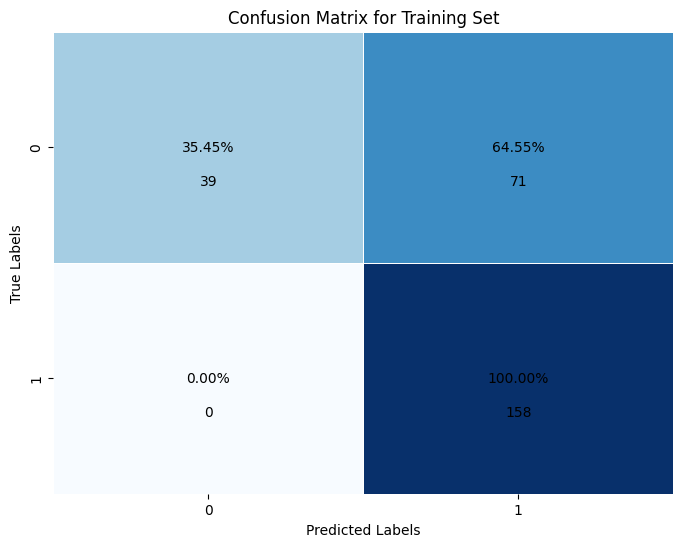

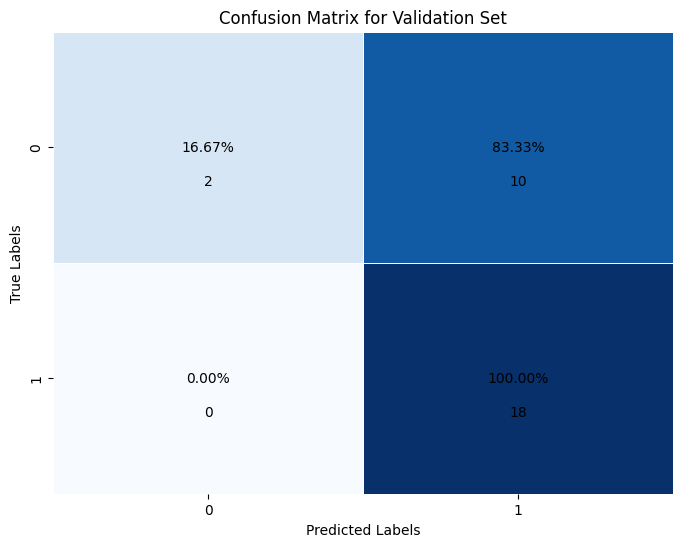

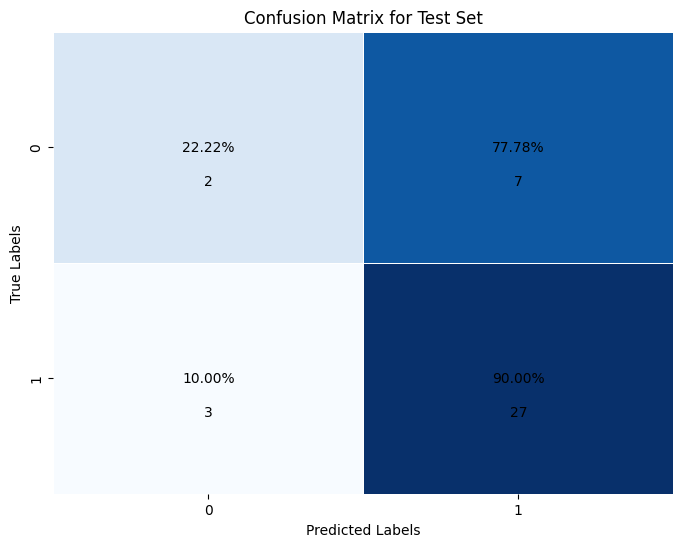

In [82]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

#  <span style = "color : red"> PubChem Fingerprint </span>

In [83]:
def fingerprint_pubchem_smiles_list(
        smiles,
        minimum_path=1,
        maximum_path=7,
        len_fingerprint=2048,
        BitsPerHash=2,
        useHs=True,
        Density=0.0,
        minimum_size=128,
        branchedPaths=True,
        useBondOrder=True,
        from_atoms=0,
        atom_invariants=0,
        atomBits=None,
        bitInfo=None
        ):
    fingerprint_rep = [None] * len(smiles)
    for i, sm in enumerate(smiles):
        mol = Chem.MolFromSmiles(sm)
        if mol is not None:
            fingerprint_bin = Chem.RDKFingerprint(mol, minPath=minimum_path, maxPath=maximum_path, fpSize=len_fingerprint, 
                                              nBitsPerHash=BitsPerHash, useHs=useHs, tgtDensity=Density, minSize=minimum_size,
                                              branchedPaths=branchedPaths, useBondOrder=useBondOrder, 
                                                atomInvariants=atom_invariants, fromAtoms=from_atoms, atomBits=atomBits,
                                                 bitInfo=bitInfo)
            fingerprint_rep[i] = fingerprint_bin.ToBitString()

    return fingerprint_rep

In [84]:
train_input_features_pubchem = fingerprint_pubchem_smiles_list(train_smile)
test_input_features_pubchem = fingerprint_pubchem_smiles_list(test_smile)

###  <span style = "color : lightgreen"> Making Train and Test Dataframe </span>

In [85]:
input_train_descriptor = []
for binary_string in train_input_features_pubchem:
    output_list = [int(bit) for bit in binary_string]
    input_train_descriptor.append(output_list)
train_descriptor_frame_pubchem = pd.DataFrame(input_train_descriptor)
train_descriptor_frame_pubchem.columns = [f'descriptor_{i+1}' for i in range(2048)]
train_descriptor_frame_pubchem['class'] = df_train['logBB_class']
train_descriptor_frame_pubchem

,descriptor_1,descriptor_2,descriptor_3,descriptor_4,descriptor_5,descriptor_6,descriptor_7,descriptor_8,descriptor_9,descriptor_10,...,descriptor_2040,descriptor_2041,descriptor_2042,descriptor_2043,descriptor_2044,descriptor_2045,descriptor_2046,descriptor_2047,descriptor_2048,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0,0,0,0,1,0,0,1,1,0,...,1,0,1,0,1,0,1,1,1,0
294,0,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
295,0,0,1,1,1,1,1,0,1,0,...,0,0,0,0,1,1,0,1,1,0
296,1,1,0,1,0,1,1,0,1,1,...,1,0,1,0,1,1,0,1,1,0


In [86]:
input_test_descriptor = []
for binary_string in test_input_features_pubchem:
    output_list = [int(bit) for bit in binary_string]
    input_test_descriptor.append(output_list)
test_descriptor_frame_pubchem = pd.DataFrame(input_test_descriptor)
test_descriptor_frame_pubchem.columns = [f'descriptor_{i+1}' for i in range(2048)]
test_descriptor_frame_pubchem['class'] = df_test['p_np']
test_descriptor_frame_pubchem

,descriptor_1,descriptor_2,descriptor_3,descriptor_4,descriptor_5,descriptor_6,descriptor_7,descriptor_8,descriptor_9,descriptor_10,...,descriptor_2040,descriptor_2041,descriptor_2042,descriptor_2043,descriptor_2044,descriptor_2045,descriptor_2046,descriptor_2047,descriptor_2048,class
0,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,1,1
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,1,1,0,1,0,0,0,0,...,0,1,1,0,1,1,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
4,0,0,1,1,1,0,0,1,1,1,...,1,0,0,1,0,0,1,0,1,0
5,1,1,0,0,1,1,1,1,1,1,...,1,1,1,0,1,1,1,1,1,0
6,1,1,0,1,0,1,1,0,0,1,...,0,0,1,1,0,1,0,1,1,1
7,1,0,0,0,0,1,0,0,0,0,...,0,1,0,1,1,0,0,0,0,1
8,1,0,1,0,0,0,0,0,0,1,...,0,1,1,1,0,0,1,1,1,1
9,0,1,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,1


##  <span style = "color : lightgreen"> Splitting into Train and Validation Set </span>

In [87]:
X = train_descriptor_frame_pubchem.drop(columns='class')
y = train_descriptor_frame_pubchem['class']
class_0 = train_descriptor_frame_pubchem[train_descriptor_frame_pubchem['class'] == 0]
class_1 = train_descriptor_frame_pubchem[train_descriptor_frame_pubchem['class'] == 1]

class_0_val = class_0.sample(frac=0.1, random_state=42)
class_1_val = class_1.sample(frac=0.1, random_state=42)

validation_set = pd.concat([class_0_val, class_1_val])

class_0_train = class_0.drop(class_0_val.index)
class_1_train = class_1.drop(class_1_val.index)

training_set = pd.concat([class_0_train, class_1_train])

X_train = training_set.drop(columns='class')
y_train = training_set['class']
X_val = validation_set.drop(columns='class')
y_val = validation_set['class']

validation_set = validation_set.reset_index().rename(columns={'index': 'index'})

validation_set.to_csv('validation_set_pubchem.csv', index=False)

print("Training set distribution:")
print(training_set['class'].value_counts())
print("Validation set distribution:")
print(validation_set['class'].value_counts())

X_test = test_descriptor_frame_pubchem.drop(columns='class')
y_test = test_descriptor_frame_pubchem['class']


Training set distribution:
class
1    158
0    110
Name: count, dtype: int64
Validation set distribution:
class
1    18
0    12
Name: count, dtype: int64


##  <span style = "color : Orange"> Random Forest </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [88]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 15],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

best_accuracy_diff = float('inf')
pubchem_best_params_rf = {}
results = []

for n_estimators in param_grid['n_estimators']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                for bootstrap in param_grid['bootstrap']:
                    for criterion in param_grid['criterion']:
                        for max_features in param_grid['max_features']:
                            rf_classifier = RandomForestClassifier(
                                n_estimators=n_estimators,
                                min_samples_leaf=min_samples_leaf,
                                bootstrap=bootstrap,
                                criterion=criterion,
                                max_features=max_features,
                                random_state=42
                            )
                            rf_classifier.fit(X_train, y_train)
                            y_pred_train = rf_classifier.predict(X_train)
                            y_pred_val = rf_classifier.predict(X_val)
                            y_pred_test = rf_classifier.predict(X_test)
                            
                            train_accuracy = accuracy_score(y_train, y_pred_train)
                            validation_accuracy = accuracy_score(y_val, y_pred_val)
                            test_accuracy = accuracy_score(y_test, y_pred_test)
                            accuracy_diff = abs(train_accuracy - test_accuracy)
                            
                            results.append({
                                'n_estimators': n_estimators,
                                'min_samples_leaf': min_samples_leaf,
                                'bootstrap': bootstrap,
                                'criterion': criterion,
                                'max_features': max_features,
                                'train_accuracy': train_accuracy,
                                'validation_accuracy': validation_accuracy,
                                'test_accuracy': test_accuracy,
                                'accuracy_diff': accuracy_diff
                            })
                            
                            if accuracy_diff < best_accuracy_diff:
                                best_accuracy_diff = accuracy_diff
                                pubchem_best_params_rf = {
                                    'n_estimators': n_estimators,
                                    'min_samples_leaf': min_samples_leaf,
                                    'bootstrap': bootstrap,
                                    'criterion': criterion,
                                    'max_features': max_features,
                                }

results_df = pd.DataFrame(results)
results_df.to_csv('rf_hyperparameter_tuning_pubchem.csv', index=False)

print("Best hyperparameters for Random Forest:")
print(pubchem_best_params_rf)



Best hyperparameters for Random Forest:
{'n_estimators': 100, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy', 'max_features': 'sqrt'}


###  <span style = "color : lightgreen"> Model Training with the best parameters and Validation </span>

In [89]:
best_rf_classifier = RandomForestClassifier(**pubchem_best_params_rf, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_rf_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7798507462686567
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.6666666666666666
--------------------------------------------------------------------------
Confusion Matrix:
[[ 4  8]
 [ 2 16]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.33      0.44        12
           1       0.67      0.89      0.76        18

    accuracy                           0.67        30
   macro avg       0.67      0.61      0.60        30
weighted avg       0.67      0.67      0.63        30

--------------------------------------------------------------------------


###  <span style = "color : lightgreen"> Model Performance on Test Set </span>

In [90]:
y_pred_test = best_rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Test Accuracy with best parameters:
0.7435897435897436
--------------------------------------------------------------------------
Confusion Matrix:
[[ 7  2]
 [ 8 22]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.78      0.58         9
           1       0.92      0.73      0.81        30

    accuracy                           0.74        39
   macro avg       0.69      0.76      0.70        39
weighted avg       0.81      0.74      0.76        39

--------------------------------------------------------------------------


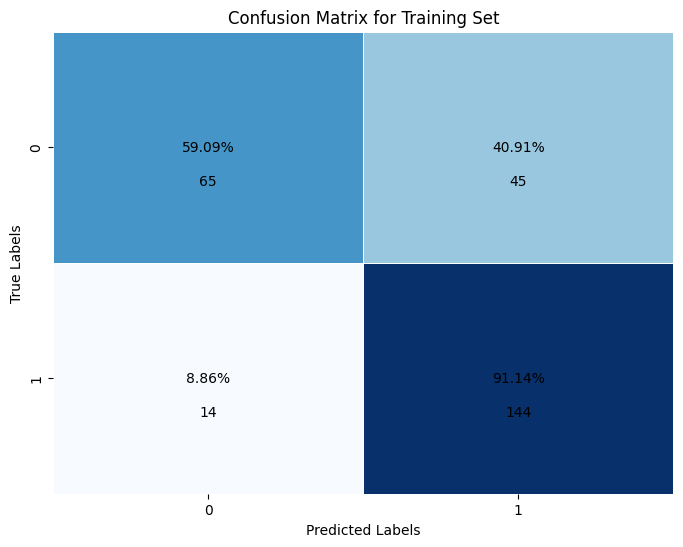

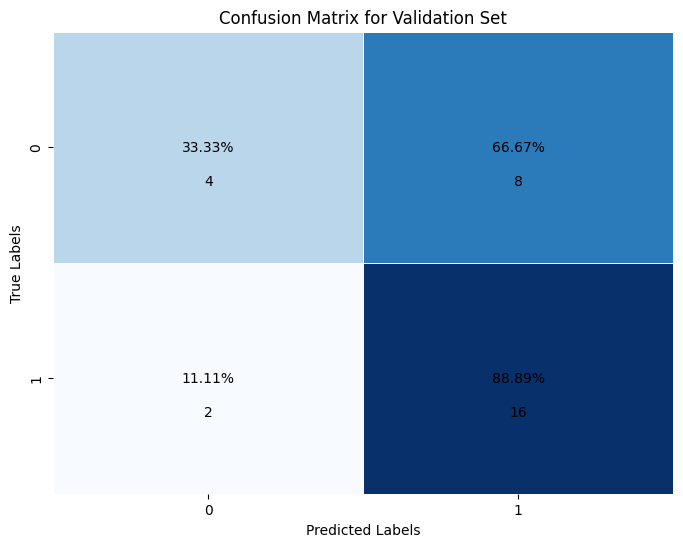

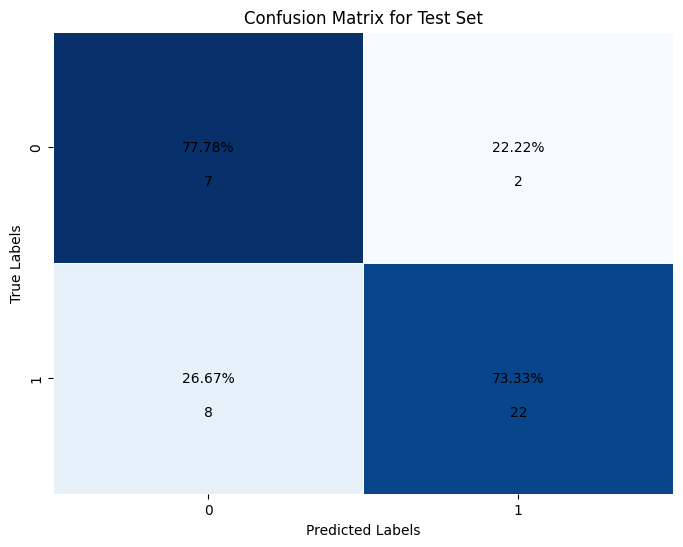

In [91]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

##  <span style = "color : Orange"> Support Vector Machine </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [92]:

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]  # only relevant for 'poly' kernel
}

best_accuracy_diff = float('inf')
pubchem_best_params_svm = {}
results = []

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:
            if kernel == 'poly':
                for degree in param_grid['degree']:
                    svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree)
                    svm_classifier.fit(X_train, y_train)
                    y_pred_train = svm_classifier.predict(X_train)
                    y_pred_val = svm_classifier.predict(X_val)
                    y_pred_test = svm_classifier.predict(X_test)
                    
                    train_accuracy = accuracy_score(y_train, y_pred_train)
                    validation_accuracy = accuracy_score(y_val, y_pred_val)
                    test_accuracy = accuracy_score(y_test, y_pred_test)
                    accuracy_diff = abs(train_accuracy - test_accuracy)
                    
                    results.append({
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel,
                        'degree': degree,
                        'train_accuracy': train_accuracy,
                        'validation_accuracy': validation_accuracy,
                        'test_accuracy': test_accuracy,
                        'accuracy_diff': accuracy_diff
                    })
                    
                    if accuracy_diff < best_accuracy_diff:
                        best_accuracy_diff = accuracy_diff
                        pubchem_best_params_svm = {
                            'C': C,
                            'gamma': gamma,
                            'kernel': kernel,
                            'degree': degree
                        }
            else:
                svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel)
                svm_classifier.fit(X_train, y_train)
                y_pred_train = svm_classifier.predict(X_train)
                y_pred_val = svm_classifier.predict(X_val)
                y_pred_test = svm_classifier.predict(X_test)
                
                train_accuracy = accuracy_score(y_train, y_pred_train)
                validation_accuracy = accuracy_score(y_val, y_pred_val)
                test_accuracy = accuracy_score(y_test, y_pred_test)
                accuracy_diff = abs(train_accuracy - test_accuracy)
                
                results.append({
                    'C': C,
                    'gamma': gamma,
                    'kernel': kernel,
                    'train_accuracy': train_accuracy,
                    'validation_accuracy': validation_accuracy,
                    'test_accuracy': test_accuracy,
                    'accuracy_diff': accuracy_diff
                })
                
                if accuracy_diff < best_accuracy_diff:
                    best_accuracy_diff = accuracy_diff
                    pubchem_best_params_svm = {
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel
                    }

results_df = pd.DataFrame(results)
results_df.to_csv('svm_hyperparameter_tuning_pubchem.csv', index=False)

print("Best hyperparameters for SVM:")
print(pubchem_best_params_svm)

Best hyperparameters for SVM:
{'C': 100, 'gamma': 'auto', 'kernel': 'poly', 'degree': 4}


###  <span style = "color : lightgreen"> Model Training with the best parameters and Validation </span>

In [93]:
if pubchem_best_params_svm['kernel'] == 'poly':
    best_svm_classifier = SVC(**pubchem_best_params_svm)
else:
    pubchem_best_params_svm.pop('degree', None)
    best_svm_classifier = SVC(**pubchem_best_params_svm)

best_svm_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_svm_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_svm_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")


--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.8171641791044776
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.6333333333333333
--------------------------------------------------------------------------
Confusion Matrix:
[[ 2 10]
 [ 1 17]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.17      0.27        12
           1       0.63      0.94      0.76        18

    accuracy                           0.63        30
   macro avg       0.65      0.56      0.51        30
weighted avg       0.64      0.63      0.56        30

--------------------------------------------------------------------------


###  <span style = "color : lightgreen"> Model Performance on Test Set </span>

In [94]:
X_test = test_descriptor_frame_pubchem.drop(columns='class')
y_test = test_descriptor_frame_pubchem['class']
y_pred_test = best_svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Test Accuracy with best parameters:
0.8205128205128205
--------------------------------------------------------------------------
Confusion Matrix:
[[ 7  2]
 [ 5 25]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.78      0.67         9
           1       0.93      0.83      0.88        30

    accuracy                           0.82        39
   macro avg       0.75      0.81      0.77        39
weighted avg       0.85      0.82      0.83        39

--------------------------------------------------------------------------


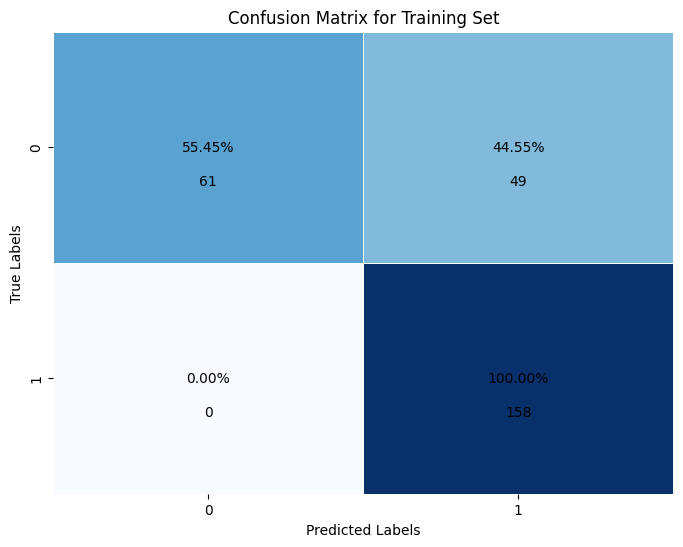

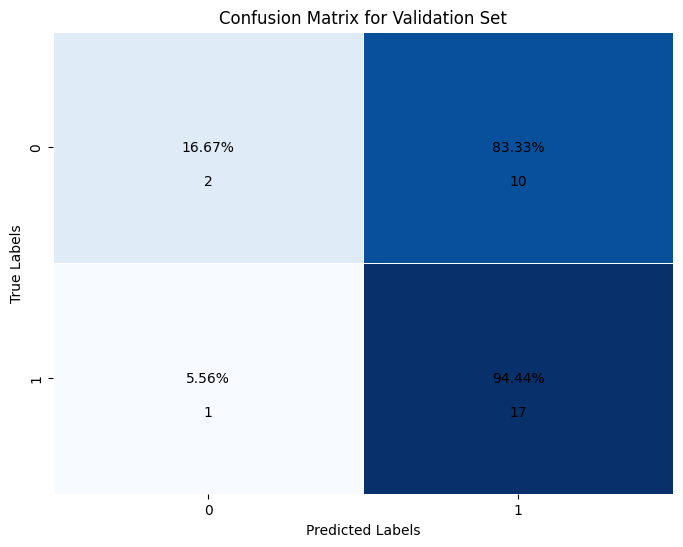

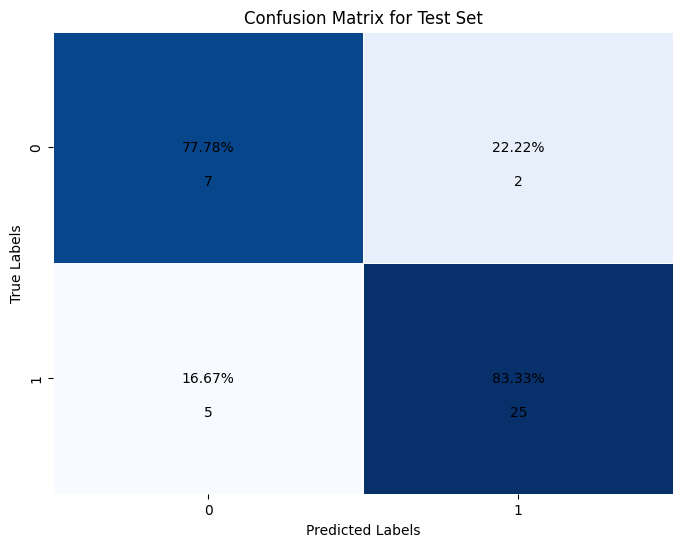

In [95]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

#  <span style = "color : red"> Substructure Fingerprint </span>

In [96]:
def fingerprint_substructure_smiles_list(
        smiles
):
    fingerprint_rep = [None] * len(smiles)

    for i, sm in enumerate(smiles):
        mol = Chem.MolFromSmiles(sm)
        if mol is not None:
            fingerprint_bin = AllChem.PatternFingerprint(mol) 
            fingerprint_rep[i] = fingerprint_bin.ToBitString()
    return fingerprint_rep 


In [97]:
train_input_features_substructure = fingerprint_substructure_smiles_list(train_smile)
test_input_features_substructure = fingerprint_substructure_smiles_list(test_smile)

###  <span style = "color : lightgreen"> Making Train and Test Dataframe </span>

In [98]:
input_train_descriptor = []
for binary_string in train_input_features_substructure:
    output_list = [int(bit) for bit in binary_string]
    input_train_descriptor.append(output_list)
train_descriptor_frame_substructure = pd.DataFrame(input_train_descriptor)
train_descriptor_frame_substructure.columns = [f'descriptor_{i+1}' for i in range(2048)]
train_descriptor_frame_substructure['class'] = df_train['logBB_class']
train_descriptor_frame_substructure

,descriptor_1,descriptor_2,descriptor_3,descriptor_4,descriptor_5,descriptor_6,descriptor_7,descriptor_8,descriptor_9,descriptor_10,...,descriptor_2040,descriptor_2041,descriptor_2042,descriptor_2043,descriptor_2044,descriptor_2045,descriptor_2046,descriptor_2047,descriptor_2048,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0,1,1,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
294,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
295,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
296,0,1,1,1,0,0,0,0,0,0,...,0,1,0,0,0,1,1,1,1,0


In [99]:
input_test_descriptor = []
for binary_string in test_input_features_substructure:
    output_list = [int(bit) for bit in binary_string]
    input_test_descriptor.append(output_list)
test_descriptor_frame_substructure = pd.DataFrame(input_test_descriptor)
test_descriptor_frame_substructure.columns = [f'descriptor_{i+1}' for i in range(2048)]
test_descriptor_frame_substructure['class'] = df_test['p_np']
test_descriptor_frame_substructure

,descriptor_1,descriptor_2,descriptor_3,descriptor_4,descriptor_5,descriptor_6,descriptor_7,descriptor_8,descriptor_9,descriptor_10,...,descriptor_2040,descriptor_2041,descriptor_2042,descriptor_2043,descriptor_2044,descriptor_2045,descriptor_2046,descriptor_2047,descriptor_2048,class
0,0,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
5,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
6,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
7,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,1
9,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1


##  <span style = "color : lightgreen"> Splitting into Train and Validation Set </span>

In [100]:
X = train_descriptor_frame_substructure.drop(columns='class')
y = train_descriptor_frame_substructure['class']
class_0 = train_descriptor_frame_substructure[train_descriptor_frame_substructure['class'] == 0]
class_1 = train_descriptor_frame_substructure[train_descriptor_frame_substructure['class'] == 1]

class_0_val = class_0.sample(frac=0.1, random_state=42)
class_1_val = class_1.sample(frac=0.1, random_state=42)

validation_set = pd.concat([class_0_val, class_1_val])

class_0_train = class_0.drop(class_0_val.index)
class_1_train = class_1.drop(class_1_val.index)

training_set = pd.concat([class_0_train, class_1_train])

X_train = training_set.drop(columns='class')
y_train = training_set['class']
X_val = validation_set.drop(columns='class')
y_val = validation_set['class']

validation_set = validation_set.reset_index().rename(columns={'index': 'index'})

validation_set.to_csv('validation_set_substructure.csv', index=False)

print("Training set distribution:")
print(training_set['class'].value_counts())
print("Validation set distribution:")
print(validation_set['class'].value_counts())

X_test = test_descriptor_frame_substructure.drop(columns='class')
y_test = test_descriptor_frame_substructure['class']


Training set distribution:
class
1    158
0    110
Name: count, dtype: int64
Validation set distribution:
class
1    18
0    12
Name: count, dtype: int64


##  <span style = "color : Orange"> Random Forest </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [101]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 15],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

best_accuracy_diff = float('inf')
substructure_best_params_rf = {}
results = []

for n_estimators in param_grid['n_estimators']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                for bootstrap in param_grid['bootstrap']:
                    for criterion in param_grid['criterion']:
                        for max_features in param_grid['max_features']:
                            rf_classifier = RandomForestClassifier(
                                n_estimators=n_estimators,
                                min_samples_leaf=min_samples_leaf,
                                bootstrap=bootstrap,
                                criterion=criterion,
                                max_features=max_features,
                                random_state=42
                            )
                            rf_classifier.fit(X_train, y_train)
                            y_pred_train = rf_classifier.predict(X_train)
                            y_pred_val = rf_classifier.predict(X_val)
                            y_pred_test = rf_classifier.predict(X_test)
                            
                            train_accuracy = accuracy_score(y_train, y_pred_train)
                            validation_accuracy = accuracy_score(y_val, y_pred_val)
                            test_accuracy = accuracy_score(y_test, y_pred_test)
                            accuracy_diff = abs(train_accuracy - test_accuracy)
                            
                            results.append({
                                'n_estimators': n_estimators,
                                'min_samples_leaf': min_samples_leaf,
                                'bootstrap': bootstrap,
                                'criterion': criterion,
                                'max_features': max_features,
                                'train_accuracy': train_accuracy,
                                'validation_accuracy': validation_accuracy,
                                'test_accuracy': test_accuracy,
                                'accuracy_diff': accuracy_diff
                            })
                            
                            if accuracy_diff < best_accuracy_diff:
                                best_accuracy_diff = accuracy_diff
                                substructure_best_params_rf = {
                                    'n_estimators': n_estimators,
                                    'min_samples_leaf': min_samples_leaf,
                                    'bootstrap': bootstrap,
                                    'criterion': criterion,
                                    'max_features': max_features,
                                }

results_df = pd.DataFrame(results)
results_df.to_csv('rf_hyperparameter_tuning_substructure.csv', index=False)

print("Best hyperparameters for Random Forest:")
print(substructure_best_params_rf)



Best hyperparameters for Random Forest:
{'n_estimators': 50, 'min_samples_leaf': 8, 'bootstrap': True, 'criterion': 'entropy', 'max_features': 'log2'}


###  <span style = "color : lightgreen"> Model Training with the best parameters and Validation </span>

In [102]:
best_rf_classifier = RandomForestClassifier(**substructure_best_params_rf, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_rf_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7649253731343284
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.7
--------------------------------------------------------------------------
Confusion Matrix:
[[ 5  7]
 [ 2 16]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.42      0.53        12
           1       0.70      0.89      0.78        18

    accuracy                           0.70        30
   macro avg       0.70      0.65      0.65        30
weighted avg       0.70      0.70      0.68        30

--------------------------------------------------------------------------


###  <span style = "color : lightgreen"> Model Performance on Test Set </span>

In [103]:
X_test = test_descriptor_frame_substructure.drop(columns='class')
y_test = test_descriptor_frame_substructure['class']
y_pred_test = best_rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Test Accuracy with best parameters:
0.7435897435897436
--------------------------------------------------------------------------
Confusion Matrix:
[[ 6  3]
 [ 7 23]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.67      0.55         9
           1       0.88      0.77      0.82        30

    accuracy                           0.74        39
   macro avg       0.67      0.72      0.68        39
weighted avg       0.79      0.74      0.76        39

--------------------------------------------------------------------------


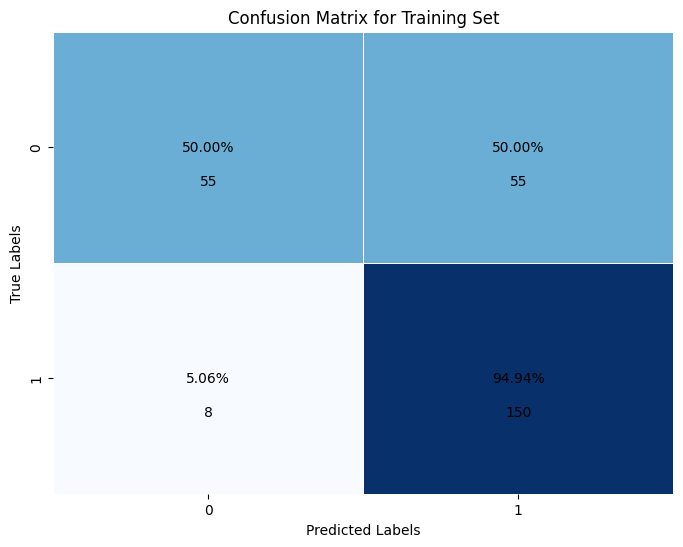

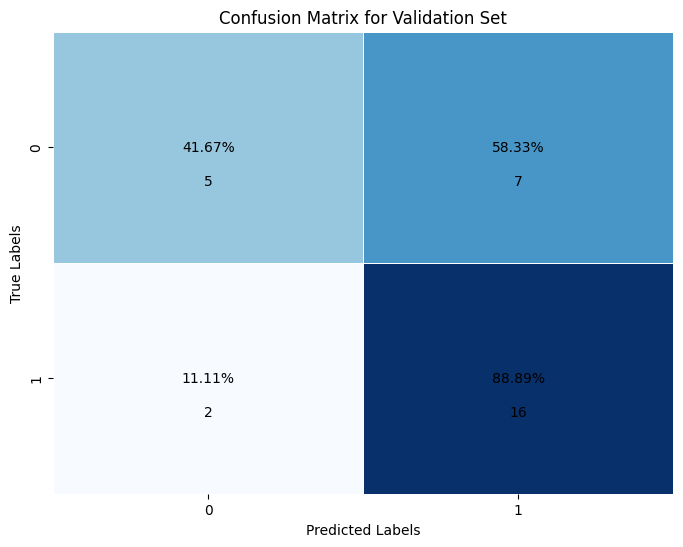

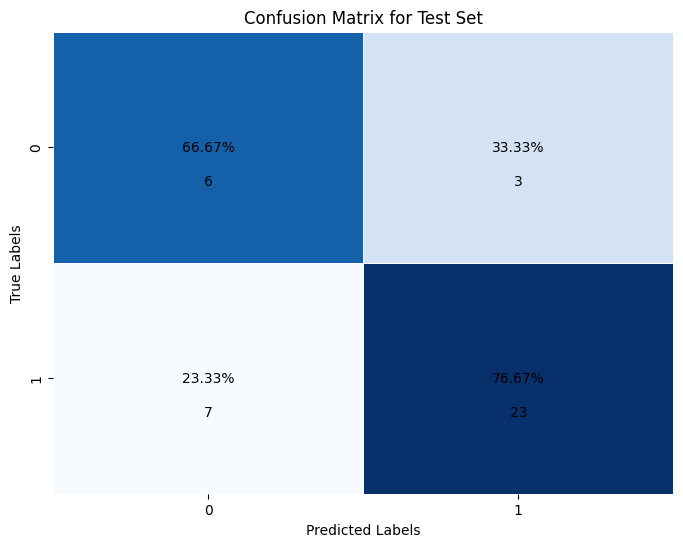

In [104]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

##  <span style = "color : Orange"> Support Vector Machine </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [105]:

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]  # only relevant for 'poly' kernel
}

best_accuracy_diff = float('inf')
substructure_best_params_svm = {}
results = []

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:
            if kernel == 'poly':
                for degree in param_grid['degree']:
                    svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree)
                    svm_classifier.fit(X_train, y_train)
                    y_pred_train = svm_classifier.predict(X_train)
                    y_pred_val = svm_classifier.predict(X_val)
                    y_pred_test = svm_classifier.predict(X_test)
                    
                    train_accuracy = accuracy_score(y_train, y_pred_train)
                    validation_accuracy = accuracy_score(y_val, y_pred_val)
                    test_accuracy = accuracy_score(y_test, y_pred_test)
                    accuracy_diff = abs(train_accuracy - test_accuracy)
                    
                    results.append({
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel,
                        'degree': degree,
                        'train_accuracy': train_accuracy,
                        'validation_accuracy': validation_accuracy,
                        'test_accuracy': test_accuracy,
                        'accuracy_diff': accuracy_diff
                    })
                    
                    if accuracy_diff < best_accuracy_diff:
                        best_accuracy_diff = accuracy_diff
                        substructure_best_params_svm = {
                            'C': C,
                            'gamma': gamma,
                            'kernel': kernel,
                            'degree': degree
                        }
            else:
                svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel)
                svm_classifier.fit(X_train, y_train)
                y_pred_train = svm_classifier.predict(X_train)
                y_pred_val = svm_classifier.predict(X_val)
                y_pred_test = svm_classifier.predict(X_test)
                
                train_accuracy = accuracy_score(y_train, y_pred_train)
                validation_accuracy = accuracy_score(y_val, y_pred_val)
                test_accuracy = accuracy_score(y_test, y_pred_test)
                accuracy_diff = abs(train_accuracy - test_accuracy)
                
                results.append({
                    'C': C,
                    'gamma': gamma,
                    'kernel': kernel,
                    'train_accuracy': train_accuracy,
                    'validation_accuracy': validation_accuracy,
                    'test_accuracy': test_accuracy,
                    'accuracy_diff': accuracy_diff
                })
                
                if accuracy_diff < best_accuracy_diff:
                    best_accuracy_diff = accuracy_diff
                    substructure_best_params_svm = {
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel
                    }

results_df = pd.DataFrame(results)
results_df.to_csv('svm_hyperparameter_tuning_substructure.csv', index=False)

print("Best hyperparameters for SVM:")
print(substructure_best_params_svm)

Best hyperparameters for SVM:
{'C': 100, 'gamma': 'auto', 'kernel': 'poly', 'degree': 3}


###  <span style = "color : lightgreen"> Model Training with the best parameters and Validation </span>

In [106]:
if substructure_best_params_svm['kernel'] == 'poly':
    best_svm_classifier = SVC(**substructure_best_params_svm)
else:
    substructure_best_params_svm.pop('degree', None)
    best_svm_classifier = SVC(**substructure_best_params_svm)

best_svm_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_svm_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_svm_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")


--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7686567164179104
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.6666666666666666
--------------------------------------------------------------------------
Confusion Matrix:
[[ 3  9]
 [ 1 17]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.25      0.38        12
           1       0.65      0.94      0.77        18

    accuracy                           0.67        30
   macro avg       0.70      0.60      0.57        30
weighted avg       0.69      0.67      0.61        30

--------------------------------------------------------------------------


###  <span style = "color : lightgreen"> Model Performance on Test Set </span>

In [107]:
y_pred_test = best_svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Test Accuracy with best parameters:
0.7692307692307693
--------------------------------------------------------------------------
Confusion Matrix:
[[ 5  4]
 [ 5 25]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.56      0.53         9
           1       0.86      0.83      0.85        30

    accuracy                           0.77        39
   macro avg       0.68      0.69      0.69        39
weighted avg       0.78      0.77      0.77        39

--------------------------------------------------------------------------


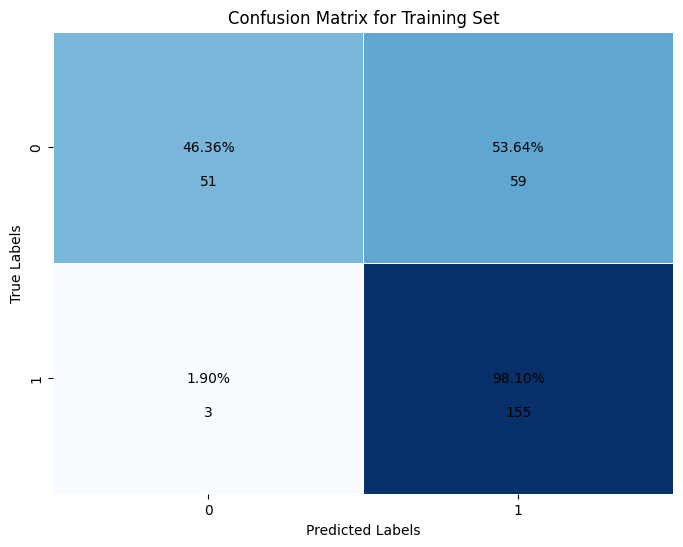

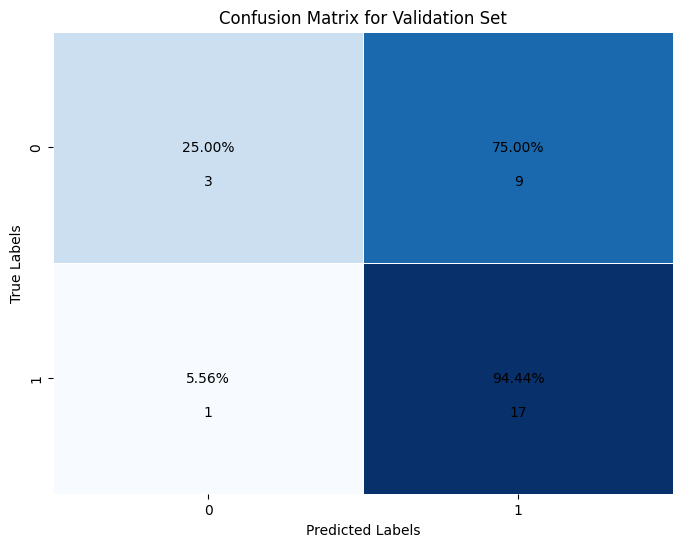

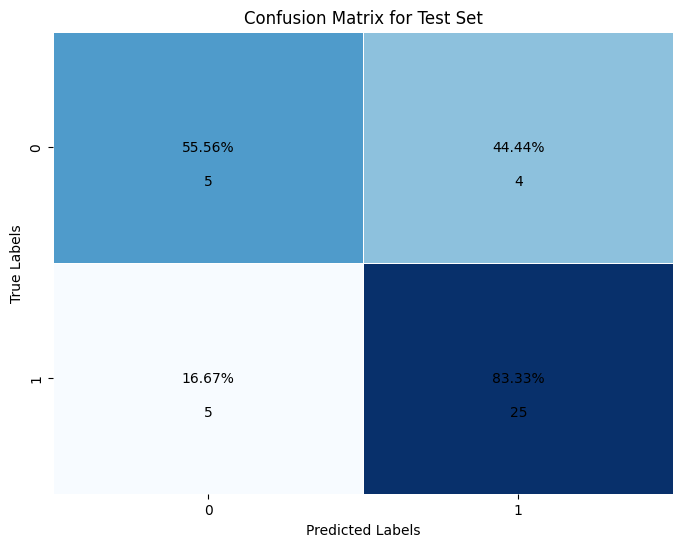

In [108]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

#  <span style = "color : red"> Topological Torsion Fingerprint </span>

In [109]:
def fingerprint_topological_torsion_smiles_list(
        smiles,
        len_fingerprint=2048,
        target_size=4,
        from_atoms=0,
        atom_invariants=0,
        ignoreAtoms=0,
        Chirality=False
):
    fingerprint_rep = [None] * len(smiles)

    for i, sm in enumerate(smiles):
        mol = Chem.MolFromSmiles(sm)
        if mol is not None:
            fingerprint_bin = AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=len_fingerprint, targetSize=target_size,
                                                                atomInvariants=atom_invariants, fromAtoms=from_atoms,ignoreAtoms=ignoreAtoms,
                                                                includeChirality=Chirality) 
            fingerprint_rep[i] = fingerprint_bin.ToBitString()

    return fingerprint_rep


In [110]:
train_input_features_topological_torsion = fingerprint_topological_torsion_smiles_list(train_smile)
test_input_features_topological_torsion = fingerprint_topological_torsion_smiles_list(test_smile)

###  <span style = "color : lightgreen"> Making Train and Test Dataframe </span>

In [111]:
input_train_descriptor = []
for binary_string in train_input_features_topological_torsion:
    output_list = [int(bit) for bit in binary_string]
    input_train_descriptor.append(output_list)
train_descriptor_frame_topological_torsion = pd.DataFrame(input_train_descriptor)
train_descriptor_frame_topological_torsion.columns = [f'descriptor_{i+1}' for i in range(2048)]
train_descriptor_frame_topological_torsion['class'] = df_train['logBB_class']
train_descriptor_frame_topological_torsion

,descriptor_1,descriptor_2,descriptor_3,descriptor_4,descriptor_5,descriptor_6,descriptor_7,descriptor_8,descriptor_9,descriptor_10,...,descriptor_2040,descriptor_2041,descriptor_2042,descriptor_2043,descriptor_2044,descriptor_2045,descriptor_2046,descriptor_2047,descriptor_2048,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
296,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0


In [112]:
input_test_descriptor = []
for binary_string in test_input_features_topological_torsion:
    output_list = [int(bit) for bit in binary_string]
    input_test_descriptor.append(output_list)
test_descriptor_frame_topological_torsion = pd.DataFrame(input_test_descriptor)
test_descriptor_frame_topological_torsion.columns = [f'descriptor_{i+1}' for i in range(2048)]
test_descriptor_frame_topological_torsion['class'] = df_test['p_np']
test_descriptor_frame_topological_torsion

,descriptor_1,descriptor_2,descriptor_3,descriptor_4,descriptor_5,descriptor_6,descriptor_7,descriptor_8,descriptor_9,descriptor_10,...,descriptor_2040,descriptor_2041,descriptor_2042,descriptor_2043,descriptor_2044,descriptor_2045,descriptor_2046,descriptor_2047,descriptor_2048,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


##  <span style = "color : lightgreen"> Splitting into Train and Validation Set </span>

In [113]:
X = train_descriptor_frame_topological_torsion.drop(columns='class')
y = train_descriptor_frame_topological_torsion['class']
class_0 = train_descriptor_frame_topological_torsion[train_descriptor_frame_topological_torsion['class'] == 0]
class_1 = train_descriptor_frame_topological_torsion[train_descriptor_frame_topological_torsion['class'] == 1]

class_0_val = class_0.sample(frac=0.1, random_state=42)
class_1_val = class_1.sample(frac=0.1, random_state=42)

validation_set = pd.concat([class_0_val, class_1_val])

class_0_train = class_0.drop(class_0_val.index)
class_1_train = class_1.drop(class_1_val.index)

training_set = pd.concat([class_0_train, class_1_train])

X_train = training_set.drop(columns='class')
y_train = training_set['class']
X_val = validation_set.drop(columns='class')
y_val = validation_set['class']

validation_set = validation_set.reset_index().rename(columns={'index': 'index'})

validation_set.to_csv('validation_set_topological_torsion.csv', index=False)

print("Training set distribution:")
print(training_set['class'].value_counts())
print("Validation set distribution:")
print(validation_set['class'].value_counts())

X_test = test_descriptor_frame_topological_torsion.drop(columns='class')
y_test = test_descriptor_frame_topological_torsion['class']


Training set distribution:
class
1    158
0    110
Name: count, dtype: int64
Validation set distribution:
class
1    18
0    12
Name: count, dtype: int64


##  <span style = "color : Orange"> Random Forest </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [114]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 15],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
}

best_accuracy_diff = float('inf')
topological_torsion_best_params_rf = {}
results = []

for n_estimators in param_grid['n_estimators']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                for bootstrap in param_grid['bootstrap']:
                    for criterion in param_grid['criterion']:
                        for max_features in param_grid['max_features']:
                            rf_classifier = RandomForestClassifier(
                                n_estimators=n_estimators,
                                min_samples_leaf=min_samples_leaf,
                                bootstrap=bootstrap,
                                criterion=criterion,
                                max_features=max_features,
                                random_state=42
                            )
                            rf_classifier.fit(X_train, y_train)
                            y_pred_train = rf_classifier.predict(X_train)
                            y_pred_val = rf_classifier.predict(X_val)
                            y_pred_test = rf_classifier.predict(X_test)
                            
                            train_accuracy = accuracy_score(y_train, y_pred_train)
                            validation_accuracy = accuracy_score(y_val, y_pred_val)
                            test_accuracy = accuracy_score(y_test, y_pred_test)
                            accuracy_diff = abs(train_accuracy - test_accuracy)
                            
                            results.append({
                                'n_estimators': n_estimators,
                                'min_samples_leaf': min_samples_leaf,
                                'bootstrap': bootstrap,
                                'criterion': criterion,
                                'max_features': max_features,
                                'train_accuracy': train_accuracy,
                                'validation_accuracy': validation_accuracy,
                                'test_accuracy': test_accuracy,
                                'accuracy_diff': accuracy_diff
                            })
                            
                            if accuracy_diff < best_accuracy_diff:
                                best_accuracy_diff = accuracy_diff
                                topological_torsion_best_params_rf = {
                                    'n_estimators': n_estimators,
                                    'min_samples_leaf': min_samples_leaf,
                                    'bootstrap': bootstrap,
                                    'criterion': criterion,
                                    'max_features': max_features,
                                }

results_df = pd.DataFrame(results)
results_df.to_csv('rf_hyperparameter_tuning_topological_torsion.csv', index=False)

print("Best hyperparameters for Random Forest:")
print(topological_torsion_best_params_rf)



Best hyperparameters for Random Forest:
{'n_estimators': 50, 'min_samples_leaf': 2, 'bootstrap': True, 'criterion': 'gini', 'max_features': 'log2'}


###  <span style = "color : lightgreen"> Model Training with the best parameters and Validation </span>

In [115]:
best_rf_classifier = RandomForestClassifier(**topological_torsion_best_params_rf, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_rf_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_rf_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.746268656716418
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.7
--------------------------------------------------------------------------
Confusion Matrix:
[[ 3  9]
 [ 0 18]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.67      1.00      0.80        18

    accuracy                           0.70        30
   macro avg       0.83      0.62      0.60        30
weighted avg       0.80      0.70      0.64        30

--------------------------------------------------------------------------


###  <span style = "color : lightgreen"> Model Performance on Test Set </span>

In [116]:
X_test = test_descriptor_frame_topological_torsion.drop(columns='class')
y_test = test_descriptor_frame_topological_torsion['class']
y_pred_test = best_rf_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Test Accuracy with best parameters:
0.7435897435897436
--------------------------------------------------------------------------
Confusion Matrix:
[[ 3  6]
 [ 4 26]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.33      0.38         9
           1       0.81      0.87      0.84        30

    accuracy                           0.74        39
   macro avg       0.62      0.60      0.61        39
weighted avg       0.72      0.74      0.73        39

--------------------------------------------------------------------------


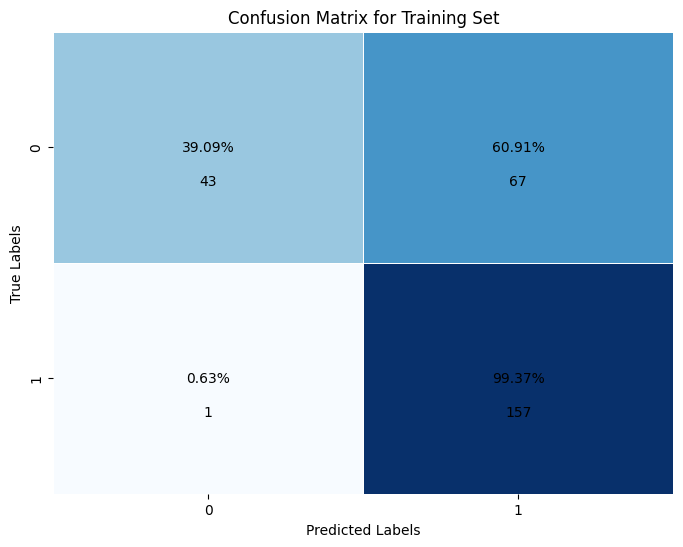

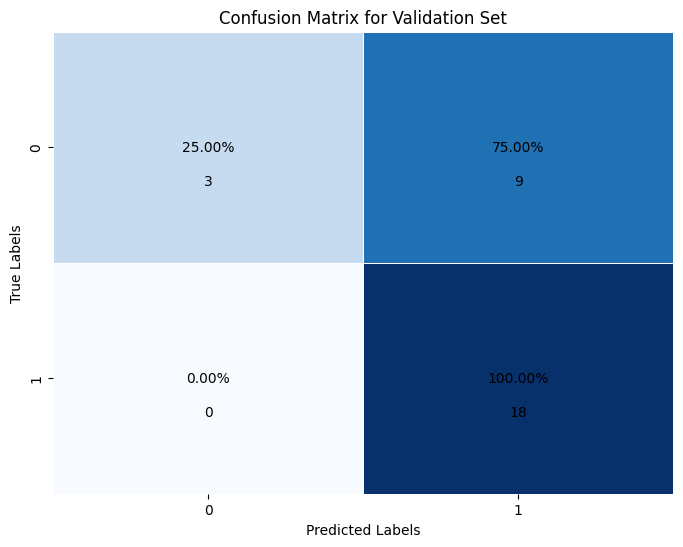

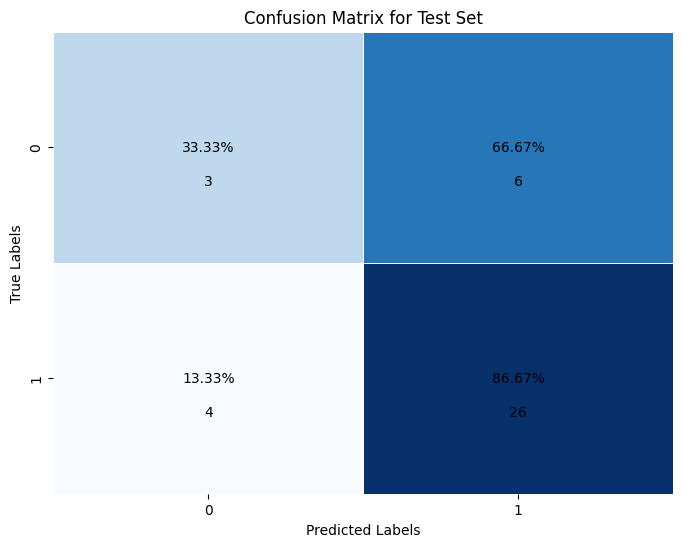

In [117]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

##  <span style = "color : Orange"> Support Vector Machine </span>

###  <span style = "color : lightgreen">  Hyperparameter Tuning to find the set of Best Parameters </span>

In [118]:

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4]  # only relevant for 'poly' kernel
}

best_accuracy_diff = float('inf')
topological_torsion_best_params_svm = {}
results = []

for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:
            if kernel == 'poly':
                for degree in param_grid['degree']:
                    svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree)
                    svm_classifier.fit(X_train, y_train)
                    y_pred_train = svm_classifier.predict(X_train)
                    y_pred_val = svm_classifier.predict(X_val)
                    y_pred_test = svm_classifier.predict(X_test)
                    
                    train_accuracy = accuracy_score(y_train, y_pred_train)
                    validation_accuracy = accuracy_score(y_val, y_pred_val)
                    test_accuracy = accuracy_score(y_test, y_pred_test)
                    accuracy_diff = abs(train_accuracy - test_accuracy)
                    
                    results.append({
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel,
                        'degree': degree,
                        'train_accuracy': train_accuracy,
                        'validation_accuracy': validation_accuracy,
                        'test_accuracy': test_accuracy,
                        'accuracy_diff': accuracy_diff
                    })
                    
                    if accuracy_diff < best_accuracy_diff:
                        best_accuracy_diff = accuracy_diff
                        topological_torsion_best_params_svm = {
                            'C': C,
                            'gamma': gamma,
                            'kernel': kernel,
                            'degree': degree
                        }
            else:
                svm_classifier = SVC(C=C, gamma=gamma, kernel=kernel)
                svm_classifier.fit(X_train, y_train)
                y_pred_train = svm_classifier.predict(X_train)
                y_pred_val = svm_classifier.predict(X_val)
                y_pred_test = svm_classifier.predict(X_test)
                
                train_accuracy = accuracy_score(y_train, y_pred_train)
                validation_accuracy = accuracy_score(y_val, y_pred_val)
                test_accuracy = accuracy_score(y_test, y_pred_test)
                accuracy_diff = abs(train_accuracy - test_accuracy)
                
                results.append({
                    'C': C,
                    'gamma': gamma,
                    'kernel': kernel,
                    'train_accuracy': train_accuracy,
                    'validation_accuracy': validation_accuracy,
                    'test_accuracy': test_accuracy,
                    'accuracy_diff': accuracy_diff
                })
                
                if accuracy_diff < best_accuracy_diff:
                    best_accuracy_diff = accuracy_diff
                    topological_torsion_best_params_svm = {
                        'C': C,
                        'gamma': gamma,
                        'kernel': kernel
                    }

results_df = pd.DataFrame(results)
results_df.to_csv('svm_hyperparameter_tuning_topological_torsion.csv', index=False)

print("Best hyperparameters for SVM:")
print(topological_torsion_best_params_svm)

Best hyperparameters for SVM:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


###  <span style = "color : lightgreen"> Model Training with the best parameters and Validation </span>

In [119]:
if topological_torsion_best_params_svm['kernel'] == 'poly':
    best_svm_classifier = SVC(**topological_torsion_best_params_svm)
else:
    topological_torsion_best_params_svm.pop('degree', None)
    best_svm_classifier = SVC(**topological_torsion_best_params_svm)

best_svm_classifier.fit(X_train, y_train)

# Training Accuracy
y_pred_train = best_svm_classifier.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("--------------------------------------------------------------------------")
print(f"Training Accuracy with best parameters:\n{train_accuracy}")
print("--------------------------------------------------------------------------")

# Validation accuracy
y_pred_val = best_svm_classifier.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_val)
conf_matrix = confusion_matrix(y_val, y_pred_val)
class_report = classification_report(y_val, y_pred_val)
print("--------------------------------------------------------------------------")
print(f"Validation Accuracy with best parameters:\n{validation_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")


--------------------------------------------------------------------------
Training Accuracy with best parameters:
0.7574626865671642
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Validation Accuracy with best parameters:
0.7
--------------------------------------------------------------------------
Confusion Matrix:
[[ 3  9]
 [ 0 18]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.67      1.00      0.80        18

    accuracy                           0.70        30
   macro avg       0.83      0.62      0.60        30
weighted avg       0.80      0.70      0.64        30

--------------------------------------------------------------------------


###  <span style = "color : lightgreen"> Model Performance on Test Set </span>

In [120]:
y_pred_test = best_svm_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)
print("--------------------------------------------------------------------------")
print(f"Test Accuracy with best parameters:\n{test_accuracy}")
print("--------------------------------------------------------------------------")
print(f"Confusion Matrix:\n{conf_matrix}")
print("--------------------------------------------------------------------------")
print(f"Classification Report:\n{class_report}")
print("--------------------------------------------------------------------------")

--------------------------------------------------------------------------
Test Accuracy with best parameters:
0.7435897435897436
--------------------------------------------------------------------------
Confusion Matrix:
[[ 4  5]
 [ 5 25]]
--------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       0.83      0.83      0.83        30

    accuracy                           0.74        39
   macro avg       0.64      0.64      0.64        39
weighted avg       0.74      0.74      0.74        39

--------------------------------------------------------------------------


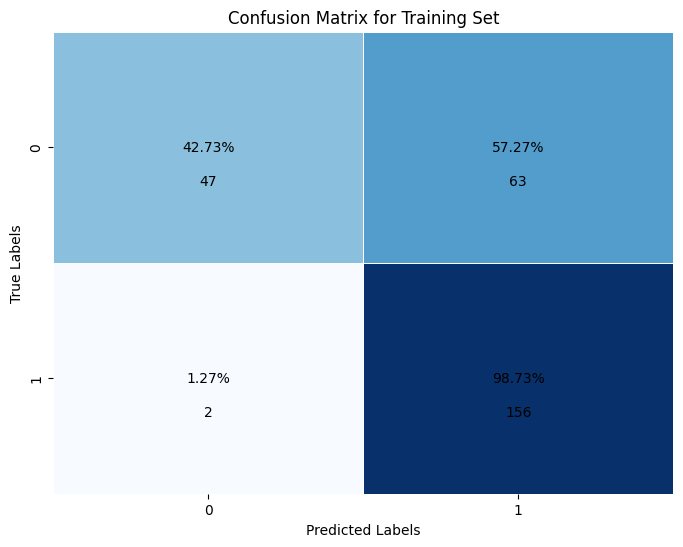

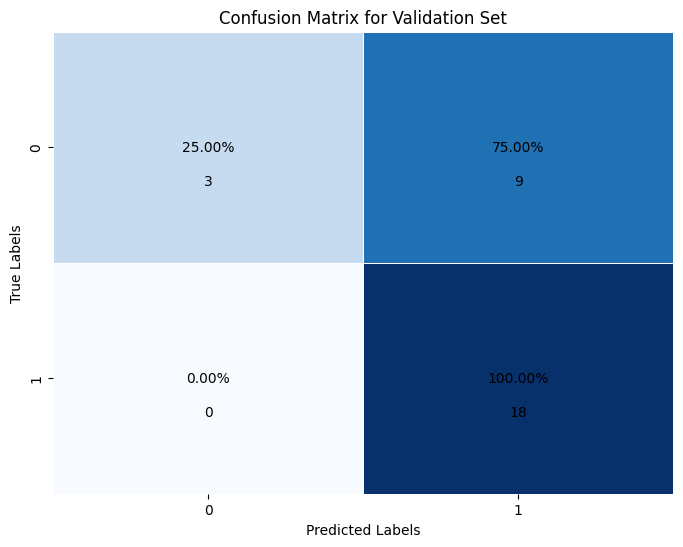

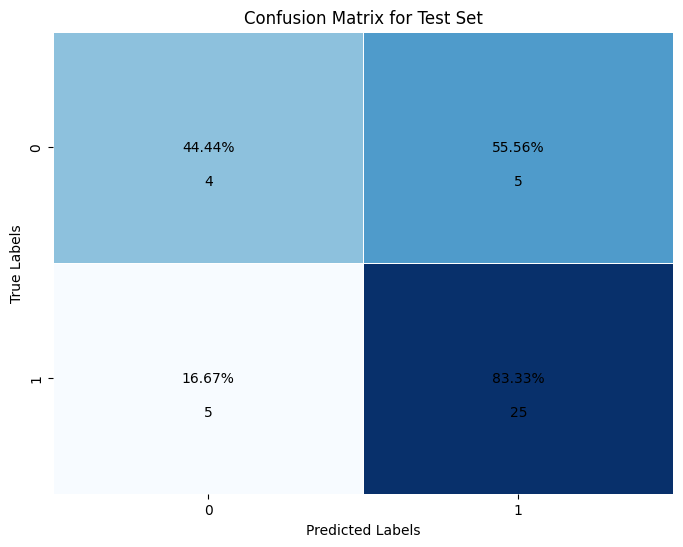

In [121]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_percent = conf_matrix / row_sums * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="Blues", cbar=False, 
                linewidths=.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j + 0.5, i + 0.5, f"{conf_matrix_percent[i, j]:.2f}%",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
            plt.text(j + 0.5, i + 0.65, f"{conf_matrix[i, j]}",
                     horizontalalignment="center",
                     verticalalignment="center", color="black", fontsize=10)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix for Training Set")
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix for Validation Set")
plot_confusion_matrix(y_test, y_pred_test, "Confusion Matrix for Test Set")

#  <span style = "color : red"> Final Result </span>

In [122]:
data = {
    ("Support Vector Machine", "Train"): [0.7873134328358209, 0.7686567164179104, 0.7574626865671642, 0.7910447761194029, 0.7686567164179104, 0.7350746268656716, 0.8171641791044776, 0.7574626865671642],
    ("Support Vector Machine", "Validation"): [0.6666666666666666, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.6666666666666666, 0.6666666666666666, 0.6333333333333333, 0.7],
    ("Support Vector Machine", "Test"): [0.8205128205128205, 0.7692307692307693, 0.8205128205128205, 0.8461538461538461, 0.7692307692307693, 0.7435897435897436, 0.8205128205128205, 0.7435897435897436],
    ("Best parameters of SVM","C"):[100,0.1,10,10,100,0.1,100,10],
    ("Best parameters of SVM","gamma"):['auto','scale','auto','auto','auto','scale','auto','auto'],
    ("Best parameters of SVM","kernel"):['poly','poly','rbf','rbf','poly','poly','poly','rbf'],
    ("Best parameters of SVM","degree"):[2,3,None,None,3,4,4,None],
    ("Random Forest", "Train"): [0.7947761194029851, 0.7798507462686567, 0.7649253731343284, 0.7723880597014925, 0.7649253731343284, 0.7164179104477612, 0.7798507462686567, 0.746268656716418],
    ("Random Forest", "Validation"): [0.6333333333333333, 0.7, 0.7333333333333333, 0.7, 0.7, 0.7333333333333333, 0.6666666666666666, 0.7],
    ("Random Forest", "Test"): [0.7948717948717948, 0.6923076923076923, 0.7692307692307693, 0.7692307692307693, 0.7435897435897436, 0.717948717948718, 0.7435897435897436, 0.7435897435897436],
    ("Best parameters of Random Forest", "n_estimators"): [100,100,50,50,50,50,100,50],
    ("Best parameters of Random Forest", "min_samples_leaf"): [6,15,8,6,8,15,15,2],
    ("Best parameters of Random Forest", "bootstrap"): [True,True,False,True,True,True,True,True],
    ("Best parameters of Random Forest", "criterion"): ['gini','gini','entropy','entropy','entropy','entropy','entropy','gini'],
    ("Best parameters of Random Forest", "max_features"): ['log2','log2','sqrt','sqrt','log2','sqrt','sqrt','log2']
}

df = pd.DataFrame(data)
df.insert(0, 'Fingerprint', ["Atom Pair", "MACCS Keys", "Morgan", "Extended Connectivity", 
                             "Substructure", "Pharmacophore", "Pubchem", "Topological Torsion"])

df


Fingerprint Support Vector Machine                       \
                                          Train Validation      Test   
0              Atom Pair               0.787313   0.666667  0.820513   
1             MACCS Keys               0.768657   0.733333  0.769231   
2                 Morgan               0.757463   0.733333  0.820513   
3  Extended Connectivity               0.791045   0.733333  0.846154   
4           Substructure               0.768657   0.666667  0.769231   
5          Pharmacophore               0.735075   0.666667  0.743590   
6                Pubchem               0.817164   0.633333  0.820513   
7    Topological Torsion               0.757463   0.700000  0.743590   

  Best parameters of SVM                      Random Forest             \
                       C  gamma kernel degree         Train Validation   
0                  100.0   auto   poly    2.0      0.794776   0.633333   
1                    0.1  scale   poly    3.0      0.779851   0.700000   
2                   10.0   auto    rbf    NaN      0.764925   0.733333   
3                   10.0   auto    rbf    NaN      0.772388   0.700000   
4                  100.0   auto   poly    3.0      0.764925   0.700000   
5                    0.1  scale   poly    4.0      0.716418   0.733333   
6                  100.0   auto   poly    4.0      0.779851   0.666667   
7                   10.0   auto    rbf    NaN      0.746269   0.700000   

            Best parameters of Random Forest                             \
       Test                     n_estimators min_samples_leaf bootstrap   
0  0.794872                              100                6      True   
1  0.692308                              100               15      True   
2  0.769231                               50                8     False   
3  0.769231                               50                6      True   
4  0.743590                               50                8      True   
5  0.717949                               50               15      True   
6  0.743590                              100               15      True   
7  0.743590                               50                2      True   

                          
  criterion max_features  
0      gini         log2  
1      gini         log2  
2   entropy         sqrt  
3   entropy         sqrt  
4   entropy         log2  
5   entropy         sqrt  
6   entropy         sqrt  
7      gini         log2

In [123]:
df.to_csv('classification_results.csv', index=False)